In [59]:
%pip install scikit-learn pandas matplotlib seaborn numpy scipy plotly numpy openpyxl
%pip install torch==2.1.0 --force-reinstall
%pip install shap
%pip install --upgrade nbformat>=4.2.0
%pip install xgboost
%pip install --upgrade kaleido
%pip install optuna
%pip install scikit-optimize
%pip install optuna-integration[pytorch-lightning]
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==2.1.0 (from versions: 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1)
ERROR: No matching distribution found for torch==2.1.0


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [60]:
import pandas as pd

df = pd.read_excel('Liu_et_al_2024.xlsx')
df.head()

,sample ID,φS (%),φA (%),DS,R2,RQI (μm),kp (10−3 μm2),km (10−3 μm2)
0,P1,0.669,2.703,2.960,0.949,0.021,0.120,0.015
1,P2,0.499,2.214,2.959,0.973,0.093,0.060,0.236
2,P3,0.495,2.627,2.962,0.861,0.014,0.059,0.006
3,P4,1.928,2.856,2.891,0.974,0.154,1.444,1.130
4,P5,2.438,3.097,2.888,0.980,0.197,2.507,2.151


In [61]:
def smart_rename(df):
    mapping = {}
    for col in df.columns:
        c = col.replace(" ", "")

        if c.startswith("φS"):
            mapping[col] = "φₛ (%)"
        elif c.startswith("φA"):
            mapping[col] = "φₐ (%)"
        elif c.lower() in ["ds", "dS", "Ds", "DS"]:
            mapping[col] = "Dₛ"
        elif c.lower() in ["r2", "R2"]:
            mapping[col] = "R²"
        elif "kp" in c.lower():
            mapping[col] = "kₚ (10⁻³ μm²)"
        elif "km" in c.lower():
            mapping[col] = "kₘ (10⁻³ μm²)"

    return df.rename(columns=mapping)

df = smart_rename(df)
df.head()

,sample ID,φₛ (%),φₐ (%),Dₛ,R²,RQI (μm),kₚ (10⁻³ μm²),kₘ (10⁻³ μm²)
0,P1,0.669,2.703,2.960,0.949,0.021,0.120,0.015
1,P2,0.499,2.214,2.959,0.973,0.093,0.060,0.236
2,P3,0.495,2.627,2.962,0.861,0.014,0.059,0.006
3,P4,1.928,2.856,2.891,0.974,0.154,1.444,1.130
4,P5,2.438,3.097,2.888,0.980,0.197,2.507,2.151


In [62]:
df.drop(columns=["R²"], inplace=True)

df.info()
df.describe()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample ID      25 non-null     object 
 1   φₛ (%)         25 non-null     float64
 2   φₐ (%)         25 non-null     float64
 3   Dₛ             25 non-null     float64
 4   RQI (μm)       25 non-null     float64
 5   kₚ (10⁻³ μm²)  25 non-null     float64
 6   kₘ (10⁻³ μm²)  25 non-null     float64
dtypes: float64(6), object(1)
memory usage: 1.5+ KB


np.int64(0)

In [63]:
df.columns

Index(['sample ID', 'φₛ (%)', 'φₐ (%)', 'Dₛ', 'RQI (μm) ', 'kₚ (10⁻³ μm²)',
       'kₘ (10⁻³ μm²)'],
      dtype='object')

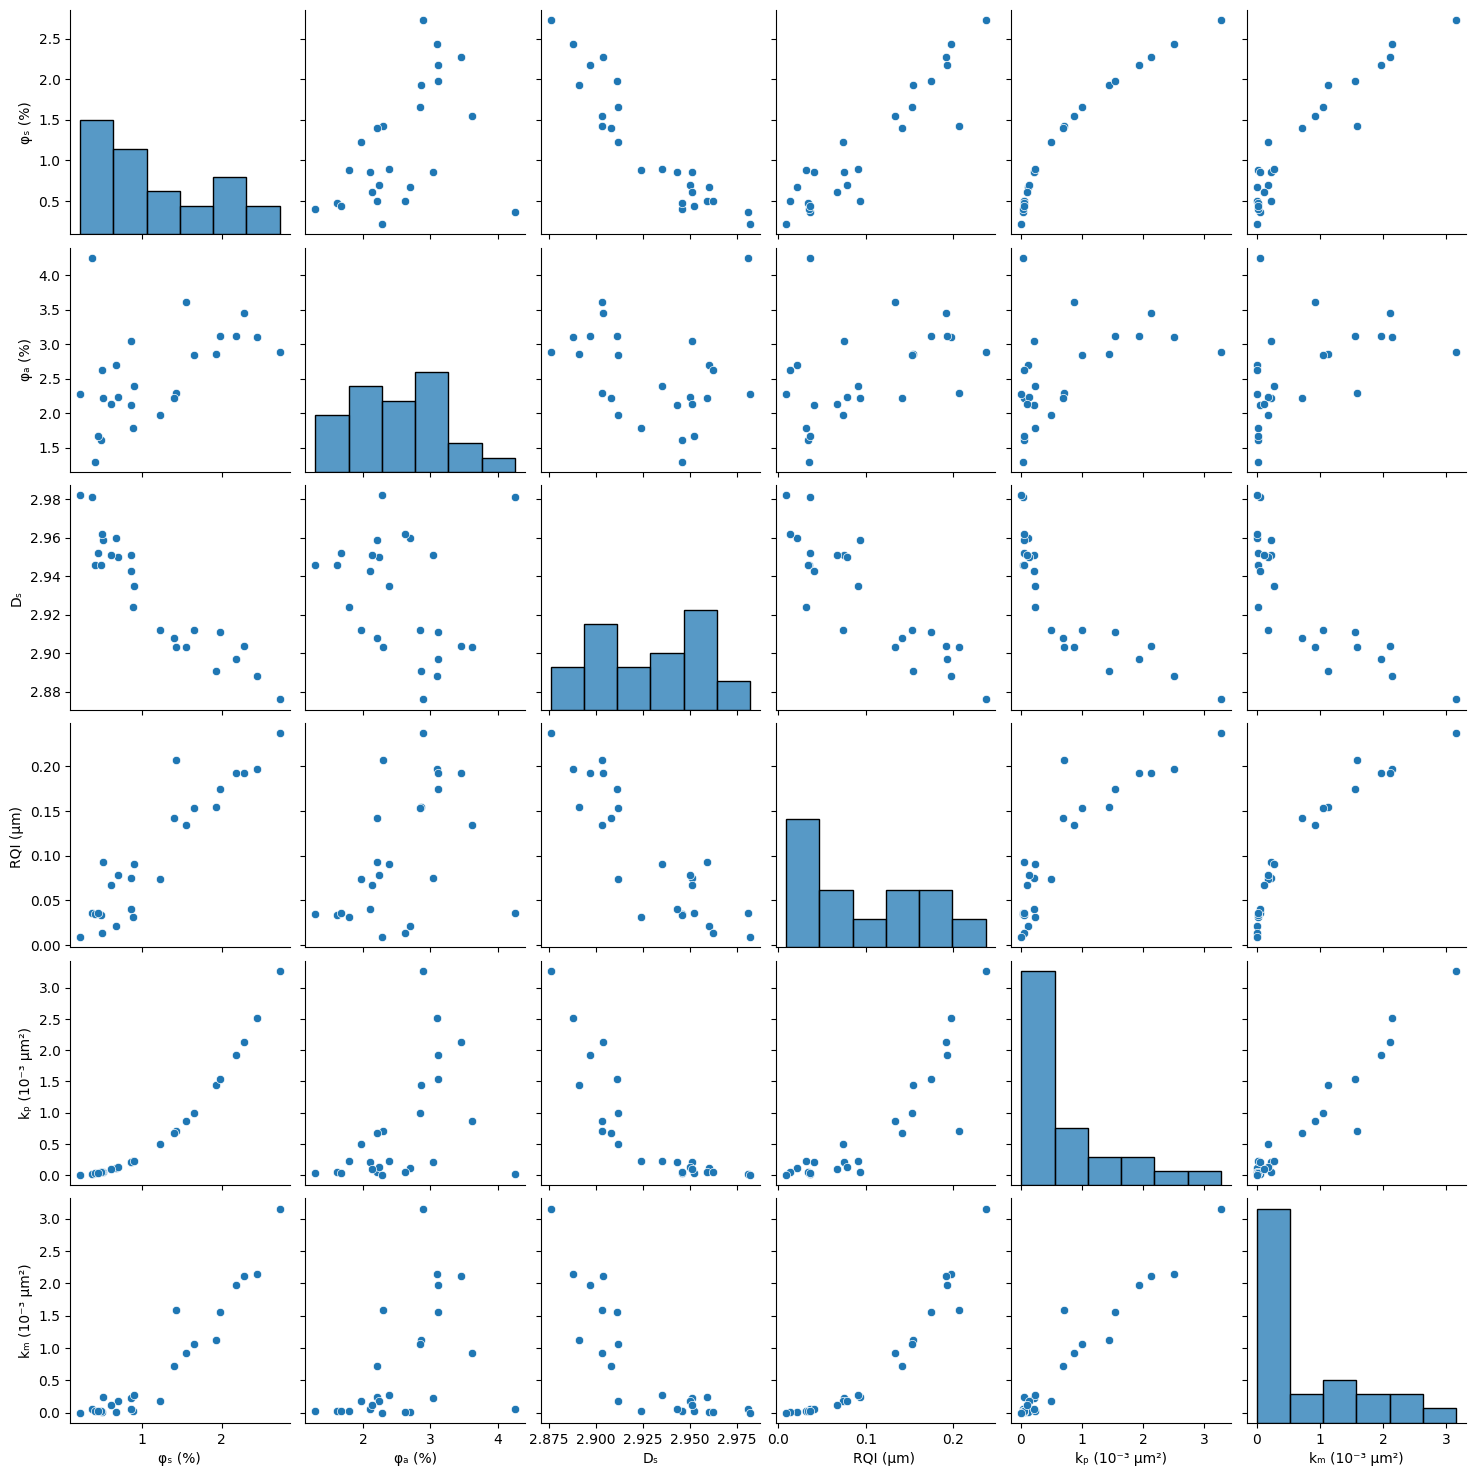

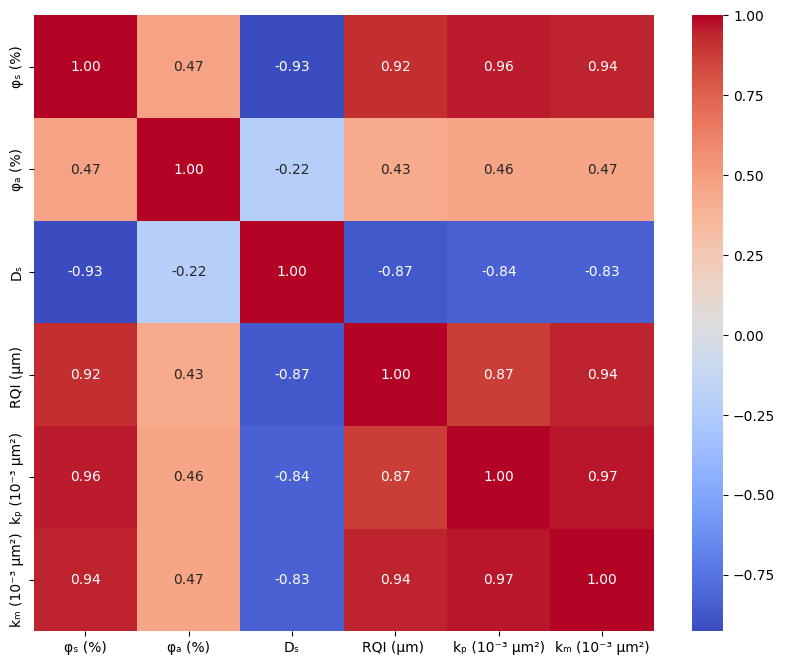

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot of numeric columns only
sns.pairplot(df.select_dtypes(include='number'))
plt.show()

# Correlation matrix of numeric columns only
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


In [65]:
# ---------------------------------------
# Exploratory Data Analysis
# ---------------------------------------

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from itertools import combinations
from scipy.interpolate import griddata

# ------------------- CONFIG -------------------
df = df.copy()
df.columns = df.columns.str.strip()
numeric_cols = ['φₛ (%)', 'φₐ (%)', 'Dₛ', 'RQI (μm)', 'kₚ (10⁻³ μm²)', 'kₘ (10⁻³ μm²)']
feature_cols = ['φₛ (%)', 'φₐ (%)', 'Dₛ', 'RQI (μm)']
mode_cols = ['kₚ (10⁻³ μm²)', 'kₘ (10⁻³ μm²)']
target_col = 'kₚ (10⁻³ μm²)'
mesh_N = 30
color_scales = ['Viridis', 'Cividis']

# ------------------- 1. Histogram Figure -------------------
hist_traces = []
for col in numeric_cols:
    trace = go.Histogram(
        x=df[col],
        nbinsx=15,
        name=col,
        visible=True
    )
    hist_traces.append(trace)

fig_hist = go.Figure(data=hist_traces)

# Dropdown buttons for each column
hist_buttons = [
    dict(label=col,
         method="update",
         args=[{"visible": [c == col for c in numeric_cols]},
               {"title": f"Histogram of {col}",
                "xaxis": {"title": col},
                "yaxis": {"title": "Count"}}])
    for col in numeric_cols
]

fig_hist.update_layout(
    updatemenus=[dict(buttons=hist_buttons, x=1, y=1.15, xanchor='left', yanchor='top')],
    title=f"Histogram of {numeric_cols[0]}",
    xaxis_title=numeric_cols[0],
    yaxis_title="Count",
    width=800, height=500
)
fig_hist.show()

# ------------------- 2. Scatterplot vs Target -------------------
scatter_traces = []
for col in feature_cols:
    trace = go.Scatter(
        x=df[col],
        y=df[target_col],
        mode='markers',
        name=col,
        visible=True
    )
    scatter_traces.append(trace)

fig_scatter = go.Figure(data=scatter_traces)

scatter_buttons = [
    dict(label=col,
         method="update",
         args=[{"visible": [c == col for c in feature_cols]},
               {"title": f"{col} vs {target_col}",
                "xaxis": {"title": col},
                "yaxis": {"title": target_col}}])
    for col in feature_cols
]

fig_scatter.update_layout(
    updatemenus=[dict(buttons=scatter_buttons, x=1, y=1.15, xanchor='left', yanchor='top')],
    title=f"{feature_cols[0]} vs {target_col}",
    xaxis_title=feature_cols[0],
    yaxis_title=target_col,
    width=800, height=500
)
fig_scatter.show()

# ------------------- 3. Pair Scatterplots -------------------
pair_options = list(combinations(feature_cols, 2))
pair_traces = []

for f1, f2 in pair_options:
    trace = go.Scatter(
        x=df[f1],
        y=df[f2],
        mode='markers',
        marker=dict(color=df[target_col], colorscale='Viridis', showscale=True),
        name=f"{f1} vs {f2}",
        visible=True
    )
    pair_traces.append(trace)

fig_pair = go.Figure(data=pair_traces)

pair_buttons = [
    dict(label=f"{f1} vs {f2}",
         method="update",
         args=[{"visible": [t.name == f"{f1} vs {f2}" for t in pair_traces]},
               {"title": f"{f1} vs {f2} colored by {target_col}",
                "xaxis": {"title": f1},
                "yaxis": {"title": f2}}])
    for f1, f2 in pair_options
]

fig_pair.update_layout(
    updatemenus=[dict(buttons=pair_buttons, x=1, y=1.15, xanchor='left', yanchor='top')],
    title=f"{pair_options[0][0]} vs {pair_options[0][1]}",
    xaxis_title=pair_options[0][0],
    yaxis_title=pair_options[0][1],
    width=800, height=500
)
fig_pair.show()

# ------------------- 4. Contour Heatmap Figure -------------------
contour_traces = []
for mode in mode_cols:
    for f1, f2 in pair_options:
        x_vals = np.linspace(df[f1].min(), df[f1].max(), mesh_N)
        y_vals = np.linspace(df[f2].min(), df[f2].max(), mesh_N)
        X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
        Z_grid = griddata(
            points=df[[f1, f2]].values,
            values=df[mode].values,
            xi=(X_grid, Y_grid),
            method='linear'
        )
        trace = go.Contour(
            x=x_vals, y=y_vals, z=Z_grid,
            colorscale='Viridis', showscale=True,
            name=f"{mode}: {f1} vs {f2}",
            visible=True,
            hovertemplate=f"{f1}: %{{x}}<br>{f2}: %{{y}}<br>{mode}: %{{z:.3f}}<extra></extra>"
        )
        contour_traces.append(trace)

fig_contour = go.Figure(data=contour_traces)

contour_buttons = [
    dict(label=f"{mode}: {f1} vs {f2}",
         method="update",
         args=[{"visible": [t.name == f"{mode}: {f1} vs {f2}" for t in contour_traces]},
               {"title": f"{mode}: {f1} vs {f2}",
                "xaxis": {"title": f1},
                "yaxis": {"title": f2}}])
    for mode in mode_cols for f1, f2 in pair_options
]

fig_contour.update_layout(
    updatemenus=[dict(buttons=contour_buttons, x=1, y=1.15, xanchor='left', yanchor='top')],
    title=f"{mode_cols[0]}: {pair_options[0][0]} vs {pair_options[0][1]}",
    xaxis_title=pair_options[0][0],
    yaxis_title=pair_options[0][1],
    width=800, height=500
)
fig_contour.show()

In [ ]:
# ======================= FULL TRAINING PIPELINE =======================
# Includes:
# - 70/15/15 split
# - Standardization
# - NAS (Optuna) + KFold CV for ANN, PINN1, PINN2, Stacked_PINN
# - Save Optuna studies + trials + plots
# - Save best hyperparameters (JSON/CSV/XLSX)
# - Bootstrap ensembles with OOB validation
# - MC Dropout prediction mean/std for all models
# - GPR baseline
# - EXACT SHAP (true Shapley values via subset enumeration) for ANN/PINNs/Stacked_PINN + GPR
# - Save artifacts + manifest + raw splits

import os, json, math, random, warnings, joblib
from collections import Counter
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.inspection import permutation_importance

import optuna
import optuna.visualization as optviz

# ------------------- REPRODUCIBILITY -------------------
warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DTYPE = torch.float32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- GLOBAL SETTINGS -------------------
KFOLD = 5
N_TRIALS = 20
BOOTSTRAP_ITERS = 20
MC_DROPOUT_ITERS = 30
BATCH_SIZE = 32

# EXACT SHAP settings
SHAP_BACKGROUND_SIZE = 50     # background size for conditional expectation approximation
SHAP_EXPLAIN_SAMPLES = None   # None = explain all training samples
SHAP_MC_ITERS = 20            # used inside SHAP prediction for neural models
SHAP_ENSEMBLE_MODELS = 5      # use up to N models from ensemble for SHAP prediction

# ------------------- SAVE DIRS -------------------
SAVE_DIR = "model_outputs"
DIRS = {k: os.path.join(SAVE_DIR, k) for k in
        ["models", "preds", "losses", "nas", "params", "shap", "data"]}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)
os.makedirs(os.path.join(DIRS["nas"], "plots"), exist_ok=True)

# ------------------- DATA -------------------
target_col = "kₚ (10⁻³ μm²)"
feature_cols = ["φₛ (%)", "φₐ (%)", "Dₛ", "RQI (μm)"]

df.columns = df.columns.str.strip()
X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

# ------------------- SPLITS (70/15/15) -------------------
X_trv, X_test, y_trv, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_trv, y_trv, test_size=0.17647, random_state=SEED)

X_train_raw, X_val_raw, X_test_raw = X_train.copy(), X_val.copy(), X_test.copy()

# Save raw splits for reproducibility
joblib.dump(X_train_raw, os.path.join(DIRS["data"], "X_train_raw.pkl"))
joblib.dump(X_val_raw,   os.path.join(DIRS["data"], "X_val_raw.pkl"))
joblib.dump(X_test_raw,  os.path.join(DIRS["data"], "X_test_raw.pkl"))
joblib.dump(y_train,     os.path.join(DIRS["data"], "y_train.pkl"))
joblib.dump(y_val,       os.path.join(DIRS["data"], "y_val.pkl"))
joblib.dump(y_test,      os.path.join(DIRS["data"], "y_test.pkl"))

# ------------------- SCALER -------------------
scaler = StandardScaler().fit(X_train_raw)
X_train_s = scaler.transform(X_train_raw).astype(np.float32)
X_val_s   = scaler.transform(X_val_raw).astype(np.float32)
X_test_s  = scaler.transform(X_test_raw).astype(np.float32)
joblib.dump(scaler, os.path.join(DIRS["models"], "scaler.pkl"))

# ------------------- DATASET -------------------
class FeatureDataset(Dataset):
    def __init__(self, Xs, Xp, y):
        self.Xs = torch.tensor(Xs, dtype=DTYPE)
        self.Xp = torch.tensor(Xp, dtype=DTYPE)
        self.y  = torch.tensor(y, dtype=DTYPE).view(-1, 1)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.Xs[i], self.Xp[i], self.y[i]

# ------------------- MODELS -------------------
class ANN(nn.Module):
    def __init__(self, d_in, hidden, dropout, act):
        super().__init__()
        act_fn = nn.ReLU if act == "relu" else nn.Tanh
        layers, d = [], d_in
        for h in hidden:
            layers += [nn.Linear(d, h), act_fn(), nn.Dropout(dropout)]
            d = h
        layers.append(nn.Linear(d, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class PINN1(nn.Module):
    def __init__(self, d_in, hidden, idx_phi_s, dropout, act):
        super().__init__()
        self.core = ANN(d_in, hidden, dropout, act)
        self.idx = idx_phi_s
        self.a_raw = nn.Parameter(torch.tensor(0.0))
        self.b = nn.Parameter(torch.tensor(1.0))
    def forward(self, x): return self.core(x)
    def phys_loss(self, Xp, yhat, lam=0.1):
        phi = Xp[:, self.idx] + 1e-8
        a = F.softplus(self.a_raw)
        k = a * phi.pow(self.b)
        return lam * F.mse_loss(yhat.view(-1), k)

class PINN2(nn.Module):
    def __init__(self, d_in, hidden, i_s, i_a, dropout, act):
        super().__init__()
        self.core = ANN(d_in, hidden, dropout, act)
        self.i_s, self.i_a = i_s, i_a
        self.c_raw = nn.Parameter(torch.tensor(0.0))
        self.m_raw = nn.Parameter(torch.tensor(0.0))
        self.n = nn.Parameter(torch.tensor(1.0))
    def forward(self, x): return self.core(x)
    def phys_loss(self, Xp, yhat, lam=0.1):
        ps, pa = Xp[:, self.i_s] + 1e-8, Xp[:, self.i_a] + 1e-8
        c, m = F.softplus(self.c_raw), F.softplus(self.m_raw)
        k = c * (ps + pa).pow(m) * (ps / pa).pow(self.n)
        return lam * F.mse_loss(yhat.view(-1), k)

# ------------------- TRAINING -------------------
def train_model(model, tr_ds, val_ds, pinn=False, lr=1e-3, epochs=500, patience=20):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    best_val, best_state, wait = np.inf, None, 0
    history = {"train_losses": [], "val_losses": []}

    for _ in range(epochs):
        model.train()
        tr_loss = 0.0
        for xs, xp, yb in DataLoader(tr_ds, BATCH_SIZE, shuffle=True):
            opt.zero_grad()
            yhat = model(xs)
            loss = mse(yhat, yb)
            if pinn:
                loss += model.phys_loss(xp, yhat)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * len(yb)
        tr_loss /= len(tr_ds)
        history["train_losses"].append(tr_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xs, xp, yb in DataLoader(val_ds, BATCH_SIZE):
                yhat = model(xs)
                loss = mse(yhat, yb)
                if pinn:
                    loss += model.phys_loss(xp, yhat)
                val_loss += loss.item() * len(yb)
        val_loss /= len(val_ds)
        history["val_losses"].append(val_loss)

        if val_loss < best_val:
            best_val, best_state, wait = val_loss, model.state_dict(), 0
        else:
            wait += 1
        if wait >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model.cpu(), history

# ------------------- NAS (Optuna) -------------------
def run_nas(model_type, Xtr_s, Xtr_raw, ytr, Xv_s, Xv_raw, yv, idxs, model_name, fold):
    def objective(trial):
        layers = trial.suggest_int("layers", 1, 3)
        hidden = [trial.suggest_int(f"h{i}", 16, 128) for i in range(layers)]
        drop = trial.suggest_float("dropout", 0.05, 0.5)
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        act = trial.suggest_categorical("act", ["relu", "tanh"])

        if model_type == "ANN":
            model, pinn = ANN(Xtr_s.shape[1], hidden, drop, act), False
        elif model_type == "PINN1":
            model, pinn = PINN1(Xtr_s.shape[1], hidden, idxs[0], drop, act), True
        else:
            model, pinn = PINN2(Xtr_s.shape[1], hidden, idxs[0], idxs[1], drop, act), True

        model, _ = train_model(
            model,
            FeatureDataset(Xtr_s, Xtr_raw, ytr),
            FeatureDataset(Xv_s, Xv_raw, yv),
            pinn=pinn,
            lr=lr
        )

        with torch.no_grad():
            yhat = model(torch.tensor(Xv_s, dtype=DTYPE)).numpy().ravel()
        return float(np.mean((yv - yhat) ** 2))

    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=SEED)
    )
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

    joblib.dump(study, os.path.join(DIRS["nas"], f"optuna_{model_name}_fold{fold}.pkl"))
    study.trials_dataframe().to_csv(
        os.path.join(DIRS["nas"], f"optuna_{model_name}_fold{fold}_trials.csv"), index=False
    )
    return study

def aggregate_nas_params(studies):
    keys = set().union(*(s.best_params.keys() for s in studies))
    agg = {}
    for k in keys:
        vals = [s.best_params.get(k) for s in studies if k in s.best_params]
        if k.startswith("h"):
            agg[k] = int(round(np.mean(vals)))
        elif isinstance(vals[0], (int, float)):
            agg[k] = float(np.mean(vals))
        else:
            agg[k] = Counter(vals).most_common(1)[0][0]
    if not any(k.startswith("h") for k in agg):
        agg["h0"] = 32
    return agg

# ------------------- BOOTSTRAP ENSEMBLE (OOB VALIDATION) -------------------
def bootstrap_ensemble(model_type, params, Xs, Xr, yb, idxs):
    models, histories = [], []
    n = len(Xs)

    for _ in range(BOOTSTRAP_ITERS):
        train_idx = np.random.choice(n, n, replace=True)
        oob_idx = np.setdiff1d(np.arange(n), np.unique(train_idx))
        if len(oob_idx) < 5:
            oob_idx = train_idx  # rare fallback

        hidden = [params[k] for k in params if k.startswith("h")]
        drop, act = params.get("dropout", 0.1), params.get("act", "relu")
        lr = params.get("lr", 1e-3)

        if model_type == "ANN":
            model, pinn = ANN(Xs.shape[1], hidden, drop, act), False
        elif model_type == "PINN1":
            model, pinn = PINN1(Xs.shape[1], hidden, idxs[0], drop, act), True
        else:
            model, pinn = PINN2(Xs.shape[1], hidden, idxs[0], idxs[1], drop, act), True

        model, hist = train_model(
            model,
            FeatureDataset(Xs[train_idx], Xr[train_idx], yb[train_idx]),
            FeatureDataset(Xs[oob_idx],   Xr[oob_idx],   yb[oob_idx]),
            pinn=pinn,
            lr=lr
        )
        models.append(model)
        histories.append(hist)

    return models, histories

# ------------------- MC DROPOUT (BATCHED, CPU) -------------------
def mc_dropout_fast_batched_cpu(models, X, batch_size=BATCH_SIZE, mc_iters=MC_DROPOUT_ITERS, n_models=3):
    n_samples = X.shape[0]
    all_preds = []
    n_models = min(n_models, len(models))
    for m in models[:n_models]:
        m.train()  # dropout ON
        mc_preds = []
        for _ in range(mc_iters):
            batch_preds = []
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                Xb = torch.tensor(X[start:end], dtype=DTYPE)
                with torch.no_grad():
                    yhat = m(Xb).detach().numpy().ravel()
                    yhat[np.isnan(yhat) | np.isinf(yhat)] = 0.0
                    batch_preds.append(yhat)
            mc_preds.append(np.concatenate(batch_preds))
        all_preds.append(np.stack(mc_preds))
    all_preds = np.stack(all_preds)  # (n_models, mc, n)
    return all_preds.mean(axis=(0, 1)), all_preds.std(axis=(0, 1))

# ------------------- STACKED FEATURES -------------------
def stack_features(X_scaled):
    pin1_mu, pin1_sd = mc_dropout_fast_batched_cpu(ensemble_models["PINN1"], X_scaled)
    pin2_mu, pin2_sd = mc_dropout_fast_batched_cpu(ensemble_models["PINN2"], X_scaled)
    return np.column_stack([pin1_mu, pin1_sd, pin2_mu, pin2_sd]).astype(np.float32)

# ------------------- PREDICTIONS TABLE -------------------
def build_table_cpu(name, y_true, X_scaled, X_stack):
    out = {"y_true": y_true}

    for m in ["ANN", "PINN1", "PINN2", "Stacked_PINN"]:
        Xin = X_stack if m == "Stacked_PINN" else X_scaled
        mu, sd = mc_dropout_fast_batched_cpu(ensemble_models[m], Xin)
        out[f"{m}_mean"], out[f"{m}_std"] = mu, sd

    mu, sd = gpr.predict(X_scaled, return_std=True)
    out["GPR_mean"], out["GPR_std"] = mu, sd

    df_out = pd.DataFrame(out)
    df_out.to_csv(os.path.join(DIRS["preds"], f"predictions_{name}.csv"), index=False)
    return df_out

# ===================== EXACT SHAP =====================
def _shapley_weights(n_features: int):
    M = n_features
    fact = [math.factorial(i) for i in range(M + 1)]
    denom = fact[M]
    w = {}
    for s in range(M):  # |S| ranges 0..M-1 when excluding i
        w[s] = fact[s] * fact[M - s - 1] / denom
    return w

def _sample_background(X_in, size):
    n = X_in.shape[0]
    size = min(size, n)
    idx = np.random.choice(n, size, replace=False)
    return X_in[idx], idx

def _sample_explain(X_in, n_explain):
    if n_explain is None or n_explain >= len(X_in):
        return X_in, np.arange(len(X_in))
    idx = np.random.choice(len(X_in), n_explain, replace=False)
    return X_in[idx], idx

def exact_shapley_values(predict_fn, X_explain, X_background, batch_size=4096):
    """
    Exact Shapley values by enumerating all subsets (feasible for 4 features).
    predict_fn: (N,D)->(N,) deterministic predictions.
    """
    X_explain = np.asarray(X_explain, dtype=np.float32)
    X_background = np.asarray(X_background, dtype=np.float32)

    N, D = X_explain.shape
    B = X_background.shape[0]
    weights = _shapley_weights(D)

    base_value = float(np.mean(predict_fn(X_background, batch_size=batch_size)))

    # all masks 0..2^D-1 as bit vectors
    masks = [np.array([(m >> j) & 1 for j in range(D)], dtype=np.int32) for m in range(2**D)]
    v = np.zeros((N, 2**D), dtype=np.float32)

    # compute v(S) = E_bg[f(x_S + bg_~S)] for each mask S
    for mi, mask in enumerate(masks):
        big = np.repeat(X_background[None, :, :], N, axis=0).reshape(N * B, D)

        for j in range(D):
            if mask[j] == 1:
                big[:, j] = np.repeat(X_explain[:, j], B)

        preds = predict_fn(big, batch_size=batch_size).reshape(N, B).mean(axis=1)
        v[:, mi] = preds.astype(np.float32)

    shap = np.zeros((N, D), dtype=np.float32)
    for j in range(D):
        for mi, mask in enumerate(masks):
            if mask[j] == 1:
                continue
            s_size = int(mask.sum())
            w = weights[s_size]
            mask_with = mask.copy()
            mask_with[j] = 1
            mi_with = int(sum((mask_with[k] << k) for k in range(D)))
            shap[:, j] += w * (v[:, mi_with] - v[:, mi])

    return shap, base_value

# ---------- deterministic wrappers for SHAP ----------
def _predict_gpr_mean(gpr_model, X, batch_size=4096):
    X = np.asarray(X, dtype=np.float32)
    preds = []
    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        preds.append(gpr_model.predict(X[start:end]).astype(np.float32))
    return np.concatenate(preds, axis=0)

def _predict_ensemble_mean(models, X, batch_size=256, mc_iters=SHAP_MC_ITERS, n_models=SHAP_ENSEMBLE_MODELS):
    X = np.asarray(X, dtype=np.float32)
    n = X.shape[0]
    n_models = min(n_models, len(models))
    all_preds = []
    for m in models[:n_models]:
        m.train()
        mc_preds = []
        for _ in range(mc_iters):
            batch_preds = []
            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                xb = torch.tensor(X[start:end], dtype=DTYPE)
                with torch.no_grad():
                    yhat = m(xb).detach().numpy().ravel()
                    yhat[np.isnan(yhat) | np.isinf(yhat)] = 0.0
                    batch_preds.append(yhat)
            mc_preds.append(np.concatenate(batch_preds))
        all_preds.append(np.stack(mc_preds))  # (mc, n)
    all_preds = np.stack(all_preds)  # (n_models, mc, n)
    return all_preds.mean(axis=(0, 1)).astype(np.float32)

# ===================== PIPELINE EXECUTION =====================
idx_phi_s = feature_cols.index("φₛ (%)")
idx_phi_a = feature_cols.index("φₐ (%)")

ensemble_models = {}
best_params = {}
nas_studies = {}
all_histories = {m: [] for m in ["ANN", "PINN1", "PINN2", "Stacked_PINN"]}

# -------- NAS + Bootstrap for ANN, PINN1, PINN2 --------
for mt in ["ANN", "PINN1", "PINN2"]:
    studies = []
    kf = KFold(KFOLD, shuffle=True, random_state=SEED)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train_s)):
        idxs = None if mt == "ANN" else (idx_phi_s,) if mt == "PINN1" else (idx_phi_s, idx_phi_a)

        study = run_nas(
            model_type=mt,
            Xtr_s=X_train_s[tr_idx], Xtr_raw=X_train_raw[tr_idx], ytr=y_train[tr_idx],
            Xv_s=X_train_s[va_idx], Xv_raw=X_train_raw[va_idx], yv=y_train[va_idx],
            idxs=idxs,
            model_name=mt,
            fold=fold
        )
        studies.append(study)

    nas_studies[mt] = studies
    best_params[mt] = aggregate_nas_params(studies)

    idxs_boot = None if mt == "ANN" else (idx_phi_s,) if mt == "PINN1" else (idx_phi_s, idx_phi_a)
    ensemble_models[mt], all_histories[mt] = bootstrap_ensemble(
        mt, best_params[mt], X_train_s, X_train_raw, y_train, idxs_boot
    )

# -------- Build stacked features for train/val/test --------
X_stack_tr = stack_features(X_train_s)
X_stack_va = stack_features(X_val_s)
X_stack_te = stack_features(X_test_s)

# -------- NAS + Bootstrap for Stacked_PINN (meta ANN) --------
stacked_studies = []
kf = KFold(KFOLD, shuffle=True, random_state=SEED)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_stack_tr)):
    study_stack = run_nas(
        model_type="ANN",
        Xtr_s=X_stack_tr[tr_idx], Xtr_raw=X_stack_tr[tr_idx], ytr=y_train[tr_idx],
        Xv_s=X_stack_tr[va_idx], Xv_raw=X_stack_tr[va_idx], yv=y_train[va_idx],
        idxs=None,
        model_name="Stacked_PINN",
        fold=fold
    )
    stacked_studies.append(study_stack)

nas_studies["Stacked_PINN"] = stacked_studies
best_params["Stacked_PINN"] = aggregate_nas_params(stacked_studies)
ensemble_models["Stacked_PINN"], all_histories["Stacked_PINN"] = bootstrap_ensemble(
    "ANN", best_params["Stacked_PINN"], X_stack_tr, X_stack_tr, y_train, idxs=None
)

# -------- GPR baseline --------
gpr = GaussianProcessRegressor(kernel=C(1.0) * RBF(), normalize_y=True)
gpr.fit(X_train_s, y_train)

# -------- Prediction tables (train/val/test) --------
df_train = build_table_cpu("train", y_train, X_train_s, X_stack_tr)
df_val   = build_table_cpu("val",   y_val,   X_val_s,   X_stack_va)
df_test  = build_table_cpu("test",  y_test,  X_test_s,  X_stack_te)

# ===================== EXACT SHAP FOR ALL MODELS =====================
# ANN/PINN1/PINN2 SHAP over X_train_s (scaled); Stacked_PINN over X_stack_tr; GPR over X_train_s.

for model_name, ens in ensemble_models.items():
    if model_name == "Stacked_PINN":
        X_in = X_stack_tr
        feat_names = ["PINN1_mean", "PINN1_std", "PINN2_mean", "PINN2_std"]
    else:
        X_in = X_train_s
        feat_names = feature_cols

    X_bg, bg_idx = _sample_background(X_in, SHAP_BACKGROUND_SIZE)
    X_exp, exp_idx = _sample_explain(X_in, SHAP_EXPLAIN_SAMPLES)

    def predict_fn_nn(Z, batch_size=256):
        return _predict_ensemble_mean(ens, Z, batch_size=batch_size)

    shap_vals, base_val = exact_shapley_values(
        predict_fn=predict_fn_nn,
        X_explain=X_exp,
        X_background=X_bg,
        batch_size=256
    )

    np.save(os.path.join(DIRS["shap"], f"{model_name}_exact_shap_values.npy"), shap_vals)
    with open(os.path.join(DIRS["shap"], f"{model_name}_exact_shap_base_value.json"), "w", encoding="utf-8") as f:
        json.dump(
            {"base_value": float(base_val),
             "background_size": int(X_bg.shape[0]),
             "explained_samples": int(X_exp.shape[0]),
             "method": "Exact Shapley values (subset enumeration)"},
            f, indent=2
        )

    shap_df = pd.DataFrame(shap_vals, columns=feat_names)
    shap_df.insert(0, "sample_index", exp_idx.astype(int))
    shap_df.to_csv(os.path.join(DIRS["shap"], f"{model_name}_exact_shap_values.csv"), index=False)

# -------- EXACT SHAP FOR GPR (baseline) --------
X_in_gpr = X_train_s
X_bg_gpr, _ = _sample_background(X_in_gpr, SHAP_BACKGROUND_SIZE)
X_exp_gpr, exp_idx_gpr = _sample_explain(X_in_gpr, SHAP_EXPLAIN_SAMPLES)

def predict_fn_gpr(Z, batch_size=4096):
    return _predict_gpr_mean(gpr, Z, batch_size=batch_size)

gpr_shap_vals, gpr_base_val = exact_shapley_values(
    predict_fn=predict_fn_gpr,
    X_explain=X_exp_gpr,
    X_background=X_bg_gpr,
    batch_size=4096
)

np.save(os.path.join(DIRS["shap"], "GPR_exact_shap_values.npy"), gpr_shap_vals)
with open(os.path.join(DIRS["shap"], "GPR_exact_shap_base_value.json"), "w", encoding="utf-8") as f:
    json.dump(
        {"base_value": float(gpr_base_val),
         "background_size": int(X_bg_gpr.shape[0]),
         "explained_samples": int(X_exp_gpr.shape[0]),
         "input_space": "scaled (StandardScaler)",
         "method": "Exact Shapley values (subset enumeration)"},
        f, indent=2
    )

gpr_shap_df = pd.DataFrame(gpr_shap_vals, columns=feature_cols)
gpr_shap_df.insert(0, "sample_index", exp_idx_gpr.astype(int))
gpr_shap_df.to_csv(os.path.join(DIRS["shap"], "GPR_exact_shap_values.csv"), index=False)

# -------- GPR permutation importance (optional benchmark) --------
perm = permutation_importance(gpr, X_train_s, y_train, n_repeats=20, random_state=SEED)
pd.DataFrame({
    "feature": feature_cols,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).to_csv(os.path.join(DIRS["shap"], "GPR_feature_importance_permutation.csv"), index=False)

# ===================== SAVE NAS OUTPUTS (STUDIES, PARAMS, TRIALS, PLOTS) =====================
joblib.dump(nas_studies, os.path.join(DIRS["nas"], "all_optuna_studies.pkl"))

# best hyperparameters JSON/CSV/XLSX
with open(os.path.join(DIRS["params"], "best_params.json"), "w", encoding="utf-8") as f:
    json.dump(best_params, f, indent=2)

all_keys = sorted(set().union(*(bp.keys() for bp in best_params.values())))
rows = []
for model_name, bp in best_params.items():
    row = {"model": model_name}
    for k in all_keys:
        row[k] = bp.get(k, np.nan)
    rows.append(row)
best_params_df = pd.DataFrame(rows)
best_params_df.to_csv(os.path.join(DIRS["params"], "best_params.csv"), index=False)
best_params_df.to_excel(os.path.join(DIRS["params"], "best_params.xlsx"), index=False)

# consolidated trials
trial_rows = []
for model_name, studies in nas_studies.items():
    for fold_idx, study in enumerate(studies):
        for t in study.trials:
            r = {
                "model": model_name,
                "fold": fold_idx,
                "trial_number": t.number,
                "value": t.value,
                "state": str(t.state),
            }
            r.update(t.params)
            trial_rows.append(r)

pd.DataFrame(trial_rows).sort_values(["model", "fold", "trial_number"]).to_csv(
    os.path.join(DIRS["nas"], "all_optuna_trials.csv"), index=False
)

# Optuna plots (HTML)
for model_name, studies in nas_studies.items():
    merged = optuna.create_study(direction="minimize")
    for s in studies:
        for t in s.trials:
            merged.add_trial(t)

    optviz.plot_optimization_history(merged).write_html(
        os.path.join(DIRS["nas"], "plots", f"{model_name}_optimization_history.html")
    )
    optviz.plot_param_importances(merged).write_html(
        os.path.join(DIRS["nas"], "plots", f"{model_name}_param_importance.html")
    )
    optviz.plot_parallel_coordinate(merged).write_html(
        os.path.join(DIRS["nas"], "plots", f"{model_name}_parallel_coordinates.html")
    )
    optviz.plot_slice(merged).write_html(
        os.path.join(DIRS["nas"], "plots", f"{model_name}_slice.html")
    )

# ===================== FINAL SAVES =====================
joblib.dump(ensemble_models, os.path.join(DIRS["models"], "ensemble_models.pkl"))
joblib.dump(gpr, os.path.join(DIRS["models"], "GPR.pkl"))
joblib.dump(all_histories, os.path.join(DIRS["losses"], "loss_histories.pkl"))

manifest = {
    "scaler": os.path.join(DIRS["models"], "scaler.pkl"),
    "ensemble_models": os.path.join(DIRS["models"], "ensemble_models.pkl"),
    "gpr": os.path.join(DIRS["models"], "GPR.pkl"),
    "loss_histories": os.path.join(DIRS["losses"], "loss_histories.pkl"),
    "best_params_json": os.path.join(DIRS["params"], "best_params.json"),
    "best_params_csv": os.path.join(DIRS["params"], "best_params.csv"),
    "best_params_xlsx": os.path.join(DIRS["params"], "best_params.xlsx"),
    "nas_all_studies_pkl": os.path.join(DIRS["nas"], "all_optuna_studies.pkl"),
    "nas_all_trials_csv": os.path.join(DIRS["nas"], "all_optuna_trials.csv"),
    "nas_plots_dir": os.path.join(DIRS["nas"], "plots"),
    "predictions_dir": DIRS["preds"],
    "shap_dir": DIRS["shap"],
    "data_dir": DIRS["data"],
}
with open(os.path.join(SAVE_DIR, "artifact_manifest.json"), "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)

print("\n[INFO] FULL PIPELINE COMPLETED.")
print("[INFO] Key outputs:")
print(" - Predictions:", DIRS["preds"])
print(" - Exact SHAP:", DIRS["shap"])
print(" - NAS studies/trials/plots:", DIRS["nas"])
print(" - Manifest:", os.path.join(SAVE_DIR, "artifact_manifest.json"))


[I 2025-12-20 21:07:32,930] A new study created in memory with name: no-name-35c23b69-3d44-41e9-832d-0685f5a9aa14
[I 2025-12-20 21:07:33,667] Trial 0 finished with value: 0.0031244931742548943 and parameters: {'layers': 2, 'h0': 123, 'h1': 98, 'dropout': 0.31939631788866646, 'lr': 0.0002051338263087451, 'act': 'relu'}. Best is trial 0 with value: 0.0031244931742548943.
[I 2025-12-20 21:07:33,769] Trial 1 finished with value: 0.2462983876466751 and parameters: {'layers': 3, 'h0': 83, 'h1': 96, 'h2': 18, 'dropout': 0.48645943347289744, 'lr': 0.004622589001020831, 'act': 'relu'}. Best is trial 0 with value: 0.0031244931742548943.
[I 2025-12-20 21:07:34,089] Trial 2 finished with value: 0.0335494726896286 and parameters: {'layers': 1, 'h0': 50, 'dropout': 0.28614039423450705, 'lr': 0.0007309539835912913, 'act': 'tanh'}. Best is trial 0 with value: 0.0031244931742548943.
[I 2025-12-20 21:07:34,270] Trial 3 finished with value: 0.003529430367052555 and parameters: {'layers': 1, 'h0': 49, 'dr


[INFO] FULL PIPELINE COMPLETED.
[INFO] Key outputs:
 - Predictions: model_outputs\preds
 - Exact SHAP: model_outputs\shap
 - NAS studies/trials/plots: model_outputs\nas
 - Manifest: model_outputs\artifact_manifest.json


In [ ]:
# ============================================================================
# FINAL VISUALIZATION SCRIPT
# ============================================================================

import os, json
import numpy as np
import pandas as pd
import joblib
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score

# ----------------------------------------------------------------------------
# Utilities
# ----------------------------------------------------------------------------
def rmse(y, yhat): return np.sqrt(np.mean((y - yhat) ** 2))
def mae(y, yhat): return np.mean(np.abs(y - yhat))
def mape(y, yhat, eps=1e-6):
    m = np.abs(y) > eps
    return np.mean(np.abs((yhat[m] - y[m]) / y[m])) * 100 if np.any(m) else np.nan

def bootstrap_metric_std(y, yhat, fn, rng, n=2000):
    idx = rng.integers(0, len(y), (n, len(y)))
    return np.std([fn(y[i], yhat[i]) for i in idx], ddof=1)

def bootstrap_shap_error(shap, rng, n=1000):
    idx = rng.integers(0, len(shap), (n, len(shap)))
    vals = [np.mean(np.abs(shap[i]), axis=0) for i in idx]
    return np.std(vals, axis=0, ddof=1)

def hex_to_rgba(hex_color, alpha=0.2):
    h = hex_color.lstrip("#")
    return f"rgba({int(h[0:2],16)},{int(h[2:4],16)},{int(h[4:6],16)},{alpha})"

# ----------------------------------------------------------------------------
# Visualizer
# ----------------------------------------------------------------------------
class PipelineVisualizerSafe:

    MODELS = ["ANN", "PINN1", "PINN2", "Stacked_PINN", "GPR"]

    COLORS = {
        "ANN": "#1f77b4",
        "PINN1": "#ff7f0e",
        "PINN2": "#9467bd",
        "Stacked_PINN": "#2ca02c",
        "GPR": "#d62728",
    }

    MARKERS = {
        "ANN": "circle",
        "PINN1": "square",
        "PINN2": "diamond",
        "Stacked_PINN": "cross",
        "GPR": "x",
    }

    def __init__(self, run_dir="model_outputs", seed=42):
        self.run_dir = run_dir
        self.plot_dir = os.path.join(run_dir, "plots")
        os.makedirs(self.plot_dir, exist_ok=True)

        self.rng = np.random.default_rng(seed)

        # Load artifacts (pipeline-faithful)
        self.histories = joblib.load(os.path.join(run_dir, "losses", "loss_histories.pkl"))
        self.feature_names = json.load(open(os.path.join(run_dir, "feature_names.json")))
        self.shap_vals = self._load_shap()
        self.preds = self._load_preds()

    # ------------------------------------------------------------------
    # Loaders
    # ------------------------------------------------------------------
    def _load_preds(self):
        return {
            k: pd.read_csv(os.path.join(self.run_dir, "preds", f"predictions_{k}.csv"))
            for k in ["train", "val", "test"]
        }

    def _load_shap(self):
        d = {}
        sd = os.path.join(self.run_dir, "shap")
        for f in os.listdir(sd):
            if f.endswith("_exact_shap_values.npy"):
                d[f.replace("_exact_shap_values.npy", "")] = np.load(os.path.join(sd, f))
        return d

    # ------------------------------------------------------------------
    # Loss curves
    # ------------------------------------------------------------------
    def plot_loss_curves(self):
        fig = make_subplots(rows=len(self.histories), cols=1,
                            subplot_titles=list(self.histories.keys()))

        for r, (m, runs) in enumerate(self.histories.items(), start=1):
            tr = np.nanmean(pd.DataFrame([h["train_losses"] for h in runs]), axis=0)
            va = np.nanmean(pd.DataFrame([h["val_losses"] for h in runs]), axis=0)

            fig.add_trace(go.Scatter(y=tr, name=f"{m} train",
                                     line=dict(color=self.COLORS[m])), r, 1)
            fig.add_trace(go.Scatter(y=va, name=f"{m} val",
                                     line=dict(color=self.COLORS[m], dash="dash")), r, 1)

            best = int(np.nanargmin(va))
            fig.add_trace(go.Scatter(
                x=[best], y=[va[best]], mode="markers",
                marker=dict(size=10, color="black"), showlegend=False
            ), r, 1)

            fig.add_annotation(
                x=best, y=va[best],
                text=f"{va[best]:.2e}<br>epoch {best}",
                showarrow=True, arrowhead=2,
                ax=0, ay=-40, row=r, col=1
            )

        fig.update_layout(title="Training & Validation Loss Curves",
                          height=300 * len(self.histories))
        fig.update_xaxes(title_text="Epoch", row=r, col=1)
        fig.update_yaxes(title_text="Loss", row=r, col=1)

        fig.write_html(os.path.join(self.plot_dir, "loss_curves.html"))
        fig.show()

    # ------------------------------------------------------------------
    # Error metrics
    # ------------------------------------------------------------------
    def plot_error_metrics(self, split="test"):
        df = self.preds[split]
        y = df["y_true"].values

        fig = make_subplots(2, 2,
                            subplot_titles=["RMSE", "MAE", "MAPE (%)", "R²"])

        for m in self.MODELS:
            yhat = df[f"{m}_mean"].values
            vals = [rmse(y, yhat), mae(y, yhat), mape(y, yhat), r2_score(y, yhat)]
            errs = [
                bootstrap_metric_std(y, yhat, rmse, self.rng),
                bootstrap_metric_std(y, yhat, mae, self.rng),
                0.0,  # MAPE uncertainty intentionally suppressed
                bootstrap_metric_std(y, yhat, r2_score, self.rng),
            ]

            for i, (v, e) in enumerate(zip(vals, errs)):
                r, c = divmod(i, 2)
                fig.add_trace(go.Bar(
                    x=[m], y=[v],
                    error_y=dict(type="data", array=[e]),
                    text=[f"{v:.3f}"],
                    textposition="outside",
                    marker_color=self.COLORS[m],
                    showlegend=False
                ), r + 1, c + 1)

        fig.update_layout(title="Error Metrics", height=700)
        fig.update_xaxes(title_text="Model")
        fig.update_yaxes(title_text="Metric Value")

        fig.write_html(os.path.join(self.plot_dir, "error_metrics.html"))
        fig.show()

    # ------------------------------------------------------------------
    # Predicted vs Actual — Train / Val / Test (±2·GPR_std)
    # ------------------------------------------------------------------
    def plot_pred_vs_actual_all_splits(self):
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=["Train", "Validation", "Test"]
        )

        for col, split in enumerate(["train", "val", "test"], start=1):
            df = self.preds[split]
            y = df["y_true"].values
            idx = np.argsort(y)

            gpr_sigma = df["GPR_std"].values

            for m in self.MODELS:
                fig.add_trace(go.Scatter(
                    x=y[idx], y=df[f"{m}_mean"].values[idx],
                    mode="markers",
                    marker=dict(
                        size=7,
                        symbol=self.MARKERS[m],
                        color=self.COLORS[m]
                    ),
                    name=m,
                    showlegend=(col == 1)
                ), 1, col)

            # ±2σ envelope (from GPR only)
            fig.add_trace(go.Scatter(
                x=y[idx], y=y[idx] + 2 * gpr_sigma[idx],
                line=dict(width=0), showlegend=False
            ), 1, col)

            fig.add_trace(go.Scatter(
                x=y[idx], y=y[idx] - 2 * gpr_sigma[idx],
                fill="tonexty",
                fillcolor="rgba(0,0,0,0.15)",
                line=dict(width=0), showlegend=False
            ), 1, col)

            fig.add_trace(go.Scatter(
                x=y[idx], y=y[idx],
                mode="lines",
                line=dict(color="black", dash="dash"),
                showlegend=False
            ), 1, col)

        fig.update_layout(
            title="Predicted vs Actual (Train / Validation / Test, ±2σ from GPR)",
            height=600
        )
        fig.update_xaxes(title_text="Actual kₚ (10⁻³ μm²)")
        fig.update_yaxes(title_text="Predicted kₚ (10⁻³ μm²)")

        fig.write_html(os.path.join(self.plot_dir, "pred_vs_actual_all_splits.html"))
        fig.show()

    # ------------------------------------------------------------------
    # Residuals
    # ------------------------------------------------------------------
    def plot_residuals(self, split="test"):
        df = self.preds[split]
        fig = go.Figure()

        for m in self.MODELS:
            fig.add_trace(go.Violin(
                y=df[f"{m}_mean"] - df["y_true"],
                name=m,
                box_visible=True,
                meanline_visible=True,
                marker_color=self.COLORS[m]
            ))

        fig.update_layout(title="Residual Distributions")
        fig.update_xaxes(title_text="Model")
        fig.update_yaxes(title_text="Residual kₚ (Predicted − Actual)")

        fig.write_html(os.path.join(self.plot_dir, "residuals.html"))
        fig.show()

    # ------------------------------------------------------------------
    # Predictive uncertainty calibration
    # ------------------------------------------------------------------
    def plot_coverage(self, split="test"):
        df = self.preds[split]
        fig = go.Figure()

        for m in self.MODELS:
            if f"{m}_std" not in df:
                continue
            err = np.abs(df[f"{m}_mean"] - df["y_true"])
            for k in [1, 2]:
                cov = np.mean(err <= k * df[f"{m}_std"])
                fig.add_trace(go.Bar(
                    x=[f"±{k}σ"],
                    y=[cov],
                    name=m,
                    text=[f"{cov:.2f}"],
                    textposition="outside",
                    marker_color=self.COLORS[m]
                ))

        fig.update_layout(
            title="Predictive Uncertainty Calibration",
            yaxis=dict(range=[0, 1.05]),
            barmode="group"
        )
        fig.update_xaxes(title_text="Uncertainty Band")
        fig.update_yaxes(title_text="Empirical Coverage Probability")

        fig.write_html(os.path.join(self.plot_dir, "coverage.html"))
        fig.show()

    # ------------------------------------------------------------------
    # SHAP
    # ------------------------------------------------------------------
    def plot_shap(self):
        fig = go.Figure()

        for m, shap in self.shap_vals.items():
            if m == "Stacked_PINN":
                continue
            vals = np.mean(np.abs(shap), axis=0)
            errs = bootstrap_shap_error(shap, self.rng)

            fig.add_trace(go.Bar(
                y=self.feature_names,
                x=vals,
                orientation="h",
                error_x=dict(type="data", array=errs),
                text=[f"{v:.3f}" for v in vals],
                textposition="outside",
                name=m
            ))

        fig.update_layout(
            title="Feature Importances",
            yaxis=dict(autorange="reversed"),
            height = 900
        )
        fig.update_xaxes(title_text="Mean |SHAP value|")
        fig.update_yaxes(title_text="Feature")

        fig.write_html(os.path.join(self.plot_dir, "shap_importance.html"))
        fig.show()

    def plot_stacked_shap(self):
        shap = self.shap_vals["Stacked_PINN"][:, [0, 2]]
        vals = np.mean(np.abs(shap), axis=0)
        errs = bootstrap_shap_error(shap, self.rng)

        fig = go.Figure(go.Bar(
            y=["PINN1_mean", "PINN2_mean"],
            x=vals,
            orientation="h",
            error_x=dict(type="data", array=errs),
            text=[f"{v:.3f}" for v in vals],
            textposition="outside",
            marker_color=self.COLORS["Stacked_PINN"]
        ))

        fig.update_layout(title="Stacked_PINN Feature Importance")
        fig.update_xaxes(title_text="Mean |SHAP value|")
        fig.update_yaxes(title_text="Feature")

        fig.write_html(os.path.join(self.plot_dir, "stacked_shap.html"))
        fig.show()

    # ------------------------------------------------------------------
    # Dominance ranking (RMSE & MAE only) 
    # ------------------------------------------------------------------
    def dominance(self, metric_fn, name, split="test"):
        df = self.preds[split]
        y = df["y_true"].values

        dist = {
            m: np.array([
                metric_fn(y[idx], df[f"{m}_mean"].values[idx])
                for idx in self.rng.integers(0, len(y), (2000, len(y)))
            ])
            for m in self.MODELS
        }

        # Pairwise dominance probabilities
        P = np.zeros((len(self.MODELS), len(self.MODELS)))
        for i, mi in enumerate(self.MODELS):
            for j, mj in enumerate(self.MODELS):
                P[i, j] = 0.5 if i == j else np.mean(dist[mi] < dist[mj])

        # ---------- dominance table ----------
        table = pd.DataFrame({
            "model": self.MODELS,
            "metric": name,
            "point_estimate": [metric_fn(y, df[f"{m}_mean"]) for m in self.MODELS],
            "dominance_score": P.mean(axis=1),
            "strong_wins(p≥0.95)": np.sum(P >= 0.95, axis=1) - 1
        }).sort_values("dominance_score", ascending=False)

        # ---------- annotated heatmap ----------
        fig = go.Figure()

        fig.add_trace(go.Heatmap(
            z=P,
            x=self.MODELS,
            y=self.MODELS,
            zmin=0,
            zmax=1,
            colorscale="Viridis",
            colorbar=dict(title=f"P(win) — {name}")
        ))

        # Add numeric annotations
        annotations = []
        for i, yi in enumerate(self.MODELS):
            for j, xj in enumerate(self.MODELS):
                annotations.append(dict(
                    x=xj,
                    y=yi,
                    text=f"{P[i, j]:.2f}",
                    showarrow=False,
                    font=dict(
                        color="white" if P[i, j] > 0.5 else "black",
                        size=12
                    )
                ))

        fig.update_layout(
            title=f"Dominance Matrix — {name}",
            annotations=annotations,
            height=600
        )
        fig.update_xaxes(title_text="Model")
        fig.update_yaxes(title_text="Model")

        fig.write_html(os.path.join(self.plot_dir, f"dominance_{name}.html"))
        fig.show()

        print(f"\n[DOMINANCE RANKING — {name}]")
        print(table.to_string(index=False))

    # ------------------------------------------------------------------
    # Master
    # ------------------------------------------------------------------
    def generate_all(self):
        self.plot_loss_curves()
        self.plot_error_metrics()
        self.plot_pred_vs_actual_all_splits()
        self.plot_residuals()
        self.plot_coverage()
        self.plot_shap()
        self.plot_stacked_shap()
        self.dominance(rmse, "RMSE")
        self.dominance(mae, "MAE")

# ----------------------------------------------------------------------------
# Run
# ----------------------------------------------------------------------------
if __name__ == "__main__":
    viz = PipelineVisualizerSafe()
    viz.generate_all()



[DOMINANCE RANKING — RMSE]
       model metric  point_estimate  dominance_score  strong_wins(p≥0.95)
         GPR   RMSE        0.003423           0.8943                    3
         ANN   RMSE        0.404553           0.4644                   -1
Stacked_PINN   RMSE        0.416015           0.3947                   -1
       PINN2   RMSE        0.485058           0.3809                   -1
       PINN1   RMSE        0.543956           0.3657                   -1



[DOMINANCE RANKING — MAE]
       model metric  point_estimate  dominance_score  strong_wins(p≥0.95)
         GPR    MAE        0.003053           0.8906                    3
         ANN    MAE        0.226485           0.4479                   -1
Stacked_PINN    MAE        0.244755           0.3998                   -1
       PINN2    MAE        0.260197           0.3943                   -1
       PINN1    MAE        0.279329           0.3674                   -1


In [ ]:
# ======================= Inference =======================

import os
import numpy as np
import torch
import joblib
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ====================== SETTINGS ======================
DTYPE = torch.float32
MC_DROPOUT_ITERS = 30

FEATURE_COLS = ["φₛ (%)", "φₐ (%)", "Dₛ", "RQI (μm)"]

MODEL_COLORS = {
    "ANN": "#1f77b4",
    "PINN1": "#ff7f0e",
    "PINN2": "#9467bd",
    "Stacked_PINN": "#2ca02c",
    "GPR": "#d62728",
}

MARKERS = {
    "ANN": "circle",
    "PINN1": "square",
    "PINN2": "diamond",
    "Stacked_PINN": "cross",
    "GPR": "x",
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================== UTILITY ======================
def resolve_path(*candidates):
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("None of the following artifact paths exist:\n" + "\n".join(candidates))

# ====================== LOAD ARTIFACTS ======================
SCALER_PATH = resolve_path("model_outputs/models/scaler.pkl")
ENSEMBLE_PATH = resolve_path("model_outputs/models/ensemble_models.pkl")
GPR_PATH = resolve_path("model_outputs/models/GPR.pkl")

scaler: StandardScaler = joblib.load(SCALER_PATH)
ensemble_models = joblib.load(ENSEMBLE_PATH)
gpr = joblib.load(GPR_PATH)

print("[INFO] Artifacts loaded successfully.")

# ====================== MC-DROPOUT PREDICTION ======================
def mc_dropout_prediction(models, X, mc_iters=MC_DROPOUT_ITERS):
    X_tensor = torch.tensor(X, dtype=DTYPE).to(DEVICE)
    all_preds = []

    for model in models:
        model.to(DEVICE)
        model.train()  # enable dropout
        mc_preds = []

        for _ in range(mc_iters):
            with torch.no_grad():
                yhat = model(X_tensor).detach().cpu().numpy().ravel()
                yhat[np.isnan(yhat) | np.isinf(yhat)] = 0.0
                mc_preds.append(yhat)

        all_preds.append(np.stack(mc_preds))

    all_preds = np.stack(all_preds)
    mean = all_preds.mean(axis=(0, 1))
    std = all_preds.std(axis=(0, 1))
    return mean, std

# ====================== STACKED PINN FEATURES ======================
def stacked_features(X_scaled):
    p1_mu, p1_sd = mc_dropout_prediction(ensemble_models["PINN1"], X_scaled)
    p2_mu, p2_sd = mc_dropout_prediction(ensemble_models["PINN2"], X_scaled)
    return np.column_stack([p1_mu, p1_sd, p2_mu, p2_sd])

# ====================== INFERENCE FUNCTION ======================
def predict_models(X_new, return_dataframe=True, visualize=True):
    """
    Run inference for ANN, PINN1, PINN2, Stacked PINN, GPR.
    Returns predictions and optionally visualizes uncertainty.
    """
    X_scaled = scaler.transform(X_new)
    sample_labels = ["Sample 7", "Sample 17", "Sample 27"]

    predictions, pred_stds = {}, {}

    # ANN / PINN1 / PINN2
    for name in ["ANN", "PINN1", "PINN2"]:
        predictions[name], pred_stds[name] = mc_dropout_prediction(ensemble_models[name], X_scaled)

    # Stacked PINN
    X_stack = stacked_features(X_scaled)
    predictions["Stacked_PINN"], pred_stds["Stacked_PINN"] = mc_dropout_prediction(
        ensemble_models["Stacked_PINN"], X_stack
    )

    # GPR
    predictions["GPR"] = gpr.predict(X_scaled)
    _, pred_stds["GPR"] = gpr.predict(X_scaled, return_std=True)

    # Visualization (COMMON ±2·GPR_std ENVELOPE)
    if visualize:
        fig = go.Figure()

        # Reference uncertainty from GPR (used for ALL models)
        gpr_sigma = pred_stds["GPR"]
        envelope_upper = predictions["GPR"] + 2 * gpr_sigma
        envelope_lower = predictions["GPR"] - 2 * gpr_sigma

        for model in predictions:
            y = predictions[model]

            r, g, b = [int(MODEL_COLORS[model][i:i+2], 16) for i in (1, 3, 5)]
            fillcolor = f"rgba({r},{g},{b},0.18)"

            # ±2σ envelope (GPR-based, shared)
            fig.add_trace(go.Scatter(
                x=sample_labels + sample_labels[::-1],
                y=np.concatenate([envelope_upper, envelope_lower[::-1]]),
                fill="toself",
                fillcolor=fillcolor,
                line=dict(width=0),
                hoverinfo="skip",
                showlegend=False
            ))

            # Mean predictions
            hover_text = [
                f"{model}<br>"
                f"Mean: {mu:.4f}<br>"
                f"±2σ (GPR): [{lo:.4f}, {up:.4f}]"
                for mu, lo, up in zip(y, envelope_lower, envelope_upper)
            ]

            fig.add_trace(go.Scatter(
                x=sample_labels,
                y=y,
                mode="lines+markers",
                name=model,
                marker=dict(
                    color=MODEL_COLORS[model],
                    symbol=MARKERS[model],
                    size=10
                ),
                line=dict(color=MODEL_COLORS[model], width=2),
                text=hover_text,
                hoverinfo="text"
            ))

        fig.update_layout(
            title="Predictions with Shared ±2σ Uncertainty Envelope (GPR-calibrated)",
            xaxis_title="Sample",
            yaxis_title="Predicted kₚ (10⁻³ μm²)",
            height=600,
            template="plotly_white",
        )
        fig.show()


    if return_dataframe:
        df = pd.DataFrame({f"{m}_mean": predictions[m] for m in predictions})
        for m in pred_stds:
            df[f"{m}_std"] = pred_stds[m]

        # Set row labels to sample names
        df.index = sample_labels

        # Save predictions
        save_path = "model_outputs/predictions_three_samples.csv"
        df.to_csv(save_path, index=True)
        print(f"[INFO] Predictions saved to {save_path}")
        return df
    else:
        return predictions, pred_stds

# ====================== EXAMPLE USAGE ======================
if __name__ == "__main__":
    X_input = np.array([
        [1.544, 3.399, 2.927, 0.066],
        [0.399, 1.559, 2.954, 0.043],
        [0.842, 2.233, 2.945, 0.022]
    ], dtype=np.float32)

    df_preds = predict_models(X_input)
    print("\n[INFO] Prediction results with ±2σ per model:")
    print(df_preds.to_string())


[INFO] Artifacts loaded successfully.


[INFO] Predictions saved to model_outputs/predictions_three_samples.csv

[INFO] Prediction results with ±2σ per model:
           ANN_mean  PINN1_mean  PINN2_mean  Stacked_PINN_mean  GPR_mean   ANN_std  PINN1_std  PINN2_std  Stacked_PINN_std   GPR_std
Sample 7   0.903802    0.790216    0.760661           0.722879  0.952179  0.271364   0.198079   0.200408          0.147297  0.064395
Sample 17  0.062129    0.084524    0.085374           0.052957  0.042573  0.060072   0.055640   0.069519          0.057786  0.004226
Sample 27  0.181664    0.196620    0.179910           0.131377  0.214559  0.074104   0.063175   0.070925          0.061796  0.004539


100%|██████████| 4/4 [00:00<00:00, 72.79it/s]


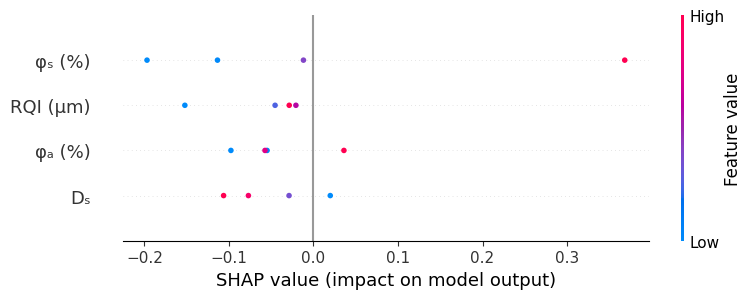

100%|██████████| 4/4 [00:00<00:00, 196.67it/s]


<Figure size 640x480 with 0 Axes>

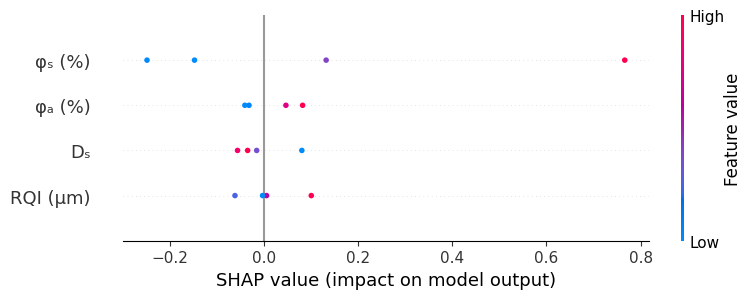

100%|██████████| 4/4 [00:00<00:00, 304.09it/s]


<Figure size 640x480 with 0 Axes>

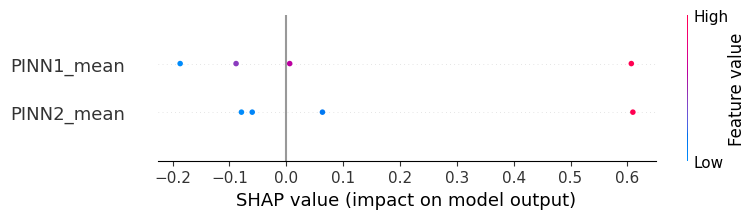

[DONE] All visualization + MC-Dropout + SHAP completed.


<Figure size 640x480 with 0 Axes>

In [ ]:
# ======================= Features Interaction Plots =======================

import os
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
from itertools import combinations
import plotly.graph_objects as go
import joblib

# ------------------ CONFIG ------------------
DISPLAY = True
SAVE_DIR = "model_outputs"
mesh_N = 30
shap_bg_size = 50
shap_sample_size = 50
seed = 42
MC_DROPOUT_ITERS = 30

# ------------------ DEVICE ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
np.random.seed(seed)

# ------------------ DIRECTORIES ------------------
viz_dir = os.path.join(SAVE_DIR, "plots_fast")
shap_dir = os.path.join(SAVE_DIR, "shap_fast")
os.makedirs(viz_dir, exist_ok=True)
os.makedirs(shap_dir, exist_ok=True)

# ------------------ LOAD MODELS ------------------
ensemble_models = joblib.load(os.path.join(SAVE_DIR, "models", "ensemble_models.pkl"))
pinn_ensemble_models = {
    "PINN1": ensemble_models.get("PINN1", []),
    "PINN2": ensemble_models.get("PINN2", []),
    "Stacked_PINN": ensemble_models.get("Stacked_PINN", [])
}
stacked_pinn_model = pinn_ensemble_models["Stacked_PINN"][0] if pinn_ensemble_models["Stacked_PINN"] else None

# ------------------ LOAD DATA ------------------
X_train_unscaled = joblib.load(os.path.join(SAVE_DIR, "data", "X_train_raw.pkl"))
X_test = joblib.load(os.path.join(SAVE_DIR, "data", "X_test_raw.pkl"))
feature_names = ["φₛ (%)","φₐ (%)","Dₛ","RQI (μm)"]
feature_indices = {n:i for i,n in enumerate(feature_names)}

# ------------------ UTILITIES ------------------
def eval_model(model, X_np):
    with torch.no_grad():
        return model(torch.tensor(X_np, dtype=torch.float32).to(device)).cpu().numpy().reshape(-1)

def mc_dropout_prediction_with_uncertainty(models, X, mc_iters=MC_DROPOUT_ITERS):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    all_preds = []
    for m in models:
        m.train()
        mc_preds = []
        for _ in range(mc_iters):
            with torch.no_grad():
                yhat = m(X_tensor).cpu().numpy().ravel()
                yhat[np.isnan(yhat) | np.isinf(yhat)] = 0.0
                mc_preds.append(yhat)
        all_preds.append(np.stack(mc_preds, axis=0))
    all_preds = np.stack(all_preds, axis=0)
    mean = all_preds.mean(axis=(0,1))
    std  = all_preds.std(axis=(0,1))
    return mean, std

def compute_kp_grid_with_uncertainty(models, feat1_vals, feat2_vals, feat1_idx, feat2_idx, mc_iters=MC_DROPOUT_ITERS):
    Yv, Xv = np.meshgrid(feat1_vals, feat2_vals, indexing='ij')
    N = Yv.size
    X_base = np.tile(X_train_unscaled.mean(axis=0), (N,1))
    X_base[:, feat1_idx] = Yv.flatten()
    X_base[:, feat2_idx] = Xv.flatten()
    mean, std = mc_dropout_prediction_with_uncertainty(models, X_base, mc_iters)
    return Yv, Xv, mean.reshape(Yv.shape), std.reshape(Yv.shape)

def compute_stacked_kp_grid_with_uncertainty(model, feat1_vals, feat2_vals, feat1_idx, feat2_idx, mc_iters=MC_DROPOUT_ITERS):
    Yv, Xv = np.meshgrid(feat1_vals, feat2_vals, indexing='ij')
    N = Yv.size
    X_base = np.tile(X_train_unscaled.mean(axis=0), (N,1))
    X_base[:, feat1_idx] = Yv.flatten()
    X_base[:, feat2_idx] = Xv.flatten()
    pinn1_mu, _ = mc_dropout_prediction_with_uncertainty(pinn_ensemble_models["PINN1"], X_base, mc_iters)
    pinn2_mu, _ = mc_dropout_prediction_with_uncertainty(pinn_ensemble_models["PINN2"], X_base, mc_iters)
    Xin = np.zeros((N, model.net[0].in_features))
    Xin[:,0] = pinn1_mu
    Xin[:,1] = pinn2_mu
    mean, std = mc_dropout_prediction_with_uncertainty([model], Xin, mc_iters)
    return Yv, Xv, mean.reshape(Yv.shape), std.reshape(Yv.shape)

# ------------------ COLORBAR POSITIONS ------------------
colorbar_positions = {
    "PINN1": dict(x=1.0, y=0.7, len=0.25),
    "PINN2": dict(x=1.0, y=0.4, len=0.25),
    "Stacked_PINN": dict(x=1.0, y=0.1, len=0.25)
}

# ------------------ REFACTORED PLOT FUNCTION ------------------
def build_plot_dropdown(feat1_vals, feat2_vals, f1, f2, i1, i2, plot_type="2D"):
    fig = go.Figure()
    models_dict = {
        "PINN1": pinn_ensemble_models["PINN1"],
        "PINN2": pinn_ensemble_models["PINN2"],
        "Stacked_PINN": [stacked_pinn_model] if stacked_pinn_model else []
    }
    colors = {"PINN1":"Blues", "PINN2":"Reds", "Stacked_PINN":"Greens"}
    traces = []
    n_traces_per_model = 1 if plot_type=="3D" else 3  # 3D shows only mean

    # Compute mean & ±2σ
    all_mean_std = {}
    for name, models in models_dict.items():
        if not models: continue
        if name=="Stacked_PINN":
            _, _, mean_kp, std_kp = compute_stacked_kp_grid_with_uncertainty(stacked_pinn_model, feat1_vals, feat2_vals, i1, i2)
        else:
            _, _, mean_kp, std_kp = compute_kp_grid_with_uncertainty(models, feat1_vals, feat2_vals, i1, i2)
        all_mean_std[name] = (mean_kp, 2*std_kp)

    # Add traces
    for name, (mean_kp, std_kp) in all_mean_std.items():
        hovertemplate = "Mean: %{z:.3f}<br>±2σ: %{customdata:.3f}<extra></extra>"
        if plot_type=="2D":
            # ±2σ contours
            for val in [mean_kp+std_kp, mean_kp-std_kp]:
                traces.append(go.Contour(z=val, x=feat2_vals, y=feat1_vals,
                                         colorscale=colors[name], opacity=0.3, showscale=False, showlegend=False))
            # Mean contour
            traces.append(go.Contour(z=mean_kp, x=feat2_vals, y=feat1_vals,
                                     colorscale=colors[name], opacity=0.8, showscale=True,
                                     colorbar=dict(title=name, **colorbar_positions[name]),
                                     contours=dict(showlabels=True),
                                     name=name, showlegend=True,
                                     hovertemplate=hovertemplate, customdata=std_kp))
        else:  # 3D surface, only mean
            traces.append(go.Surface(z=mean_kp, x=feat2_vals, y=feat1_vals,
                                     colorscale=colors[name], showscale=True,
                                     colorbar=dict(title=name, **colorbar_positions[name]),
                                     name=name, showlegend=True,
                                     hovertemplate=hovertemplate, customdata=std_kp))

    for tr in traces: fig.add_trace(tr)

    # Dropdown buttons
    model_names = list(models_dict.keys())
    buttons = []
    n_traces_total = len(traces)
    all_visibility = [True]*n_traces_total
    buttons.append(dict(label="All", method="update", args=[{"visible": all_visibility},
                                                            {"title": f"{f1} vs {f2} - All Models"}]))
    for idx, name in enumerate(model_names):
        vis = [False]*n_traces_total
        start = idx*n_traces_per_model
        for j in range(n_traces_per_model): vis[start+j] = True
        buttons.append(dict(label=name, method="update", args=[{"visible": vis},
                                                               {"title": f"{f1} vs {f2} - {name}"}]))

    # Combined hover for ±2σ (optional)
    mesh_shape = all_mean_std["PINN1"][0].shape
    combined_customdata = np.stack([all_mean_std.get("PINN1",[np.zeros(mesh_shape),np.zeros(mesh_shape)])[1],
                                    all_mean_std.get("PINN2",[np.zeros(mesh_shape),np.zeros(mesh_shape)])[1],
                                    all_mean_std.get("Stacked_PINN",[np.zeros(mesh_shape),np.zeros(mesh_shape)])[1]], axis=-1)
    if plot_type=="2D":
        traces.append(go.Contour(z=all_mean_std["PINN1"][0], x=feat2_vals, y=feat1_vals,
                                 colorscale="Viridis", opacity=0.0, showscale=False, name="All Hover",
                                 showlegend=False, customdata=combined_customdata,
                                 hovertemplate=(
                                     "PINN1 ±2σ: %{customdata[:,:,0]:.3f}<br>"
                                     "PINN2 ±2σ: %{customdata[:,:,1]:.3f}<br>"
                                     "Stacked ±2σ: %{customdata[:,:,2]:.3f}<extra></extra>"
                                 )))
    else:
        traces.append(go.Surface(z=all_mean_std["PINN1"][0], x=feat2_vals, y=feat1_vals,
                                 colorscale="Viridis", opacity=0.0, showscale=False, name="All Hover",
                                 showlegend=False, customdata=combined_customdata,
                                 hovertemplate=(
                                     "PINN1 ±2σ: %{customdata[:,:,0]:.3f}<br>"
                                     "PINN2 ±2σ: %{customdata[:,:,1]:.3f}<br>"
                                     "Stacked ±2σ: %{customdata[:,:,2]:.3f}<extra></extra>"
                                 )))

    layout_updates = dict(updatemenus=[dict(active=0, buttons=buttons, x=1.2, y=1.2)])
    if plot_type=="2D":
        layout_updates.update(title=f"{f1} vs {f2} 2D Contour", width=900, height=600,
                              xaxis_title=f2, yaxis_title=f1)
    else:
        layout_updates.update(title=f"{f1} vs {f2} 3D Surface", width=900, height=700,
                              scene=dict(xaxis_title=f2, yaxis_title=f1, zaxis_title="k"))

    fig.update_layout(**layout_updates)
    return fig

# ------------------ SHAP ANALYSIS ------------------
rng = np.random.default_rng(seed)
bg_idx = rng.choice(len(X_train_unscaled), min(shap_bg_size, len(X_train_unscaled)), replace=False)
X_bg = X_train_unscaled[bg_idx]
X_samp = X_test[:min(shap_sample_size, len(X_test))]

def fast_shap_analysis(model, model_name, X_bg, X_samp):
    if model_name=="Stacked_PINN":
        pinn1_bg = eval_model(pinn_ensemble_models["PINN1"][0], X_bg)
        pinn2_bg = eval_model(pinn_ensemble_models["PINN2"][0], X_bg)
        pinn1_s = eval_model(pinn_ensemble_models["PINN1"][0], X_samp)
        pinn2_s = eval_model(pinn_ensemble_models["PINN2"][0], X_samp)
        X_bg_full = np.column_stack([pinn1_bg, np.zeros_like(pinn1_bg), pinn2_bg, np.zeros_like(pinn2_bg)])
        X_s_full  = np.column_stack([pinn1_s, np.zeros_like(pinn1_s), pinn2_s, np.zeros_like(pinn2_s)])
        def wrapper(Xr):
            Xf = np.zeros((Xr.shape[0], X_s_full.shape[1]))
            Xf[:,0] = Xr[:,0]; Xf[:,2] = Xr[:,1]
            Xf[:,1] = X_bg_full[:,1].mean(); Xf[:,3] = X_bg_full[:,3].mean()
            return eval_model(model, Xf)
        explainer = shap.KernelExplainer(wrapper, X_bg_full[:,[0,2]])
        shap_vals = explainer(X_s_full[:,[0,2]]).values
        shap_feat_names = ["PINN1_mean","PINN2_mean"]
    else:
        explainer = shap.KernelExplainer(lambda X: eval_model(model,X), X_bg)
        shap_vals = explainer(X_samp).values
        shap_feat_names = feature_names

    plt.figure(figsize=(8,5))
    shap.summary_plot(shap_vals, X_samp if model_name!="Stacked_PINN" else X_s_full[:,[0,2]], 
                      feature_names=shap_feat_names, show=DISPLAY)
    plt.tight_layout()
    plt.savefig(os.path.join(shap_dir,f"shap_summary_{model_name}.png"), dpi=150)
    if not DISPLAY: plt.close()

# ------------------ RUN VISUALIZATION ------------------
for f1, f2 in combinations(feature_names, 2):
    i1, i2 = feature_indices[f1], feature_indices[f2]
    a1, a2 = X_train_unscaled[:, i1], X_train_unscaled[:, i2]
    pad1, pad2 = 0.02*(a1.max()-a1.min()+1e-6), 0.02*(a2.max()-a2.min()+1e-6)
    v1 = np.linspace(a1.min()-pad1, a1.max()+pad1, mesh_N)
    v2 = np.linspace(a2.min()-pad2, a2.max()+pad2, mesh_N)

    fig2d = build_plot_dropdown(v1, v2, f1, f2, i1, i2, plot_type="2D")
    fig2d.write_html(os.path.join(viz_dir, f"contour2d_{f1}_vs_{f2}_dropdown.html"))
    if DISPLAY: fig2d.show()

    fig3d = build_plot_dropdown(v1, v2, f1, f2, i1, i2, plot_type="3D")
    fig3d.write_html(os.path.join(viz_dir, f"surface3d_{f1}_vs_{f2}_dropdown.html"))
    if DISPLAY: fig3d.show()

# ------------------ SHAP ------------------
for name, models in pinn_ensemble_models.items():
    if not models: continue
    fast_shap_analysis(models[0], name, X_bg, X_samp)

print("[DONE] All visualization + MC-Dropout + SHAP completed.")


In [ ]:
"""
Physics-Violation Diagnostics + Predictive Uncertainty Visualization
- ANN, PINN1, PINN2, Stacked_PINN, GPR
- Physics violation metrics
- MC-Dropout / Ensemble uncertainty
- Heatmaps, overlays, correlations
"""

import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from scipy.stats import pearsonr, spearmanr

# ====================== CONFIG ======================
SAVE_DIR = "./"
DIRS = {
    "figures": os.path.join(SAVE_DIR, "figures"),
    "preds": os.path.join(SAVE_DIR, "preds")
}
os.makedirs(DIRS["figures"], exist_ok=True)
os.makedirs(DIRS["preds"], exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pio.renderers.default = "vscode"

MC_SAMPLES = 30

feature_cols = ["φₛ (%)", "φₐ (%)", "Dₛ", "RQI (μm)"]
idx_phi_s = feature_cols.index("φₛ (%)")
idx_phi_a = feature_cols.index("φₐ (%)")

# ====================== MC DROPOUT ======================
def mc_dropout_ensemble(models, X, n_samples=MC_SAMPLES):
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32).to(DEVICE)

    preds = []

    for model in models:
        model.to(DEVICE)
        model.eval()

        # Enable dropout layers
        for m in model.modules():
            if isinstance(m, torch.nn.Dropout):
                m.train()

        with torch.no_grad():
            for _ in range(n_samples):
                preds.append(model(X).cpu().numpy().ravel())

    preds = np.array(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# ====================== PHYSICS VIOLATIONS ======================
def physics_violation_pinn1(model, X_phys, y_pred):
    phi_s = torch.tensor(X_phys[:, idx_phi_s], dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        a = F.softplus(model.a_raw)
        b = model.b
        k_phys = a * phi_s.pow(b)
    return np.abs(y_pred - k_phys.cpu().numpy())

def physics_violation_pinn2(model, X_phys, y_pred):
    ps = torch.tensor(X_phys[:, idx_phi_s], dtype=torch.float32).to(DEVICE)
    pa = torch.tensor(X_phys[:, idx_phi_a], dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        c = F.softplus(model.c_raw)
        m = F.softplus(model.m_raw)
        n = model.n
        k_phys = c * (ps + pa).pow(m) * (ps / (pa + 1e-8)).pow(n)
    return np.abs(y_pred - k_phys.cpu().numpy())

def physics_violation_baseline(y_pred, y_true):
    return np.abs(y_pred - y_true)

# ====================== PREDICTION CORE ======================
def get_model_predictions_and_uncertainty(
    model_name, ensembles, X_scaled, X_phys, y_true=None, gpr_model=None
):
    if model_name == "Stacked_PINN":
        p1_mu, p1_sd = mc_dropout_ensemble(ensembles["PINN1"], X_scaled)
        p2_mu, p2_sd = mc_dropout_ensemble(ensembles["PINN2"], X_scaled)
        X_input = np.column_stack([p1_mu, p1_sd, p2_mu, p2_sd])
    else:
        X_input = X_scaled

    if model_name == "GPR":
        mean_pred, std_pred = gpr_model.predict(X_scaled, return_std=True)
        violations = physics_violation_baseline(mean_pred, y_true)

    else:
        mean_pred, std_pred = mc_dropout_ensemble(ensembles[model_name], X_input)

        if model_name == "PINN1":
            violations = physics_violation_pinn1(ensembles["PINN1"][0], X_phys, mean_pred)
        elif model_name == "PINN2":
            violations = physics_violation_pinn2(ensembles["PINN2"][0], X_phys, mean_pred)
        else:
            violations = physics_violation_baseline(mean_pred, y_true)

    # Correlations
    pearson_corr = pearsonr(violations, std_pred)[0] if np.std(std_pred) > 0 else np.nan
    spearman_corr = spearmanr(violations, std_pred)[0] if np.std(std_pred) > 0 else np.nan

    # Regions
    unc_thr = np.median(std_pred)
    viol_thr = np.percentile(violations, 75)
    region = np.where(
        (std_pred <= unc_thr) & (violations <= viol_thr), "Safe",
        np.where(std_pred > unc_thr, "High Uncertainty", "Physics Violating")
    )

    df = pd.DataFrame({
        "model": model_name,
        "prediction_mean": mean_pred,
        "prediction_std": std_pred,
        "physics_violation": violations,
        "log_violation": np.log10(violations + 1e-8),
        "region": region,
        feature_cols[idx_phi_s]: X_phys[:, idx_phi_s],
        feature_cols[idx_phi_a]: X_phys[:, idx_phi_a],
    })

    return df, pearson_corr, spearman_corr

# ====================== PLOTTING ======================
def plot_overlay(dfs):
    fig = go.Figure()
    for df in dfs:
        fig.add_trace(go.Scatter(
            x=df["physics_violation"],
            y=df["prediction_std"],
            mode="markers",
            name=df["model"].iloc[0],
            opacity=0.6
        ))
    fig.update_layout(
        title="Physics Violation vs Predictive Uncertainty",
        xaxis_title="|ŷ − k_phys|",
        yaxis_title="Uncertainty (σ)",
        template="plotly_white"
    )
    fig.show()
    fig.write_html(os.path.join(DIRS["figures"], "overlay_violation_uncertainty.html"))

def plot_heatmap(df, model, z_col, title, fname, colorscale):
    fig = px.density_heatmap(
        df,
        x=feature_cols[idx_phi_s],
        y=feature_cols[idx_phi_a],
        z=z_col,
        histfunc="avg",
        nbinsx=30,
        nbinsy=30,
        color_continuous_scale=colorscale,
        title=f"{model}: {title}"
    )
    fig.update_layout(template="plotly_white")
    fig.show()
    fig.write_html(os.path.join(DIRS["figures"], fname))

# ====================== MAIN RUNNER ======================
def run_physics_violation_diagnostics(
    ensembles, X_scaled, X_phys, y_true, gpr_model
):
    dfs = []
    corr = {}

    for model in ensembles:
        df, p, s = get_model_predictions_and_uncertainty(
            model, ensembles, X_scaled, X_phys, y_true, gpr_model
        )
        dfs.append(df)
        corr[model] = {"pearson": p, "spearman": s}

        df.to_csv(os.path.join(DIRS["preds"], f"{model}_diagnostics.csv"), index=False)

        plot_heatmap(df, model, "physics_violation",
                     "Physics Violation Heatmap",
                     f"{model}_violation_heatmap.html", "Viridis")

        plot_heatmap(df, model, "prediction_std",
                     "Uncertainty Heatmap",
                     f"{model}_uncertainty_heatmap.html", "Plasma")

    plot_overlay(dfs)
    pd.DataFrame(corr).to_csv(os.path.join(DIRS["figures"], "violation_uncertainty_correlations.csv"))
    print("[DONE] Physics-violation diagnostics complete.")

# ====================== EXECUTION ======================
models_to_analyze = {
    "ANN": ensemble_models["ANN"],
    "PINN1": ensemble_models["PINN1"],
    "PINN2": ensemble_models["PINN2"],
    "Stacked_PINN": ensemble_models["Stacked_PINN"],
    "GPR": gpr
}

run_physics_violation_diagnostics(
    models_to_analyze,
    X_test_s,
    X_test_raw,
    y_test,
    gpr_model=gpr
)

[DONE] Physics-violation diagnostics complete.


In [ ]:
"""
Physics-Violation Diagnostics + Predictive Uncertainty Visualization
- ANN, PINN1, PINN2, Stacked_PINN, GPR
- Physics violation metrics
- MC-Dropout / Ensemble uncertainty
- Heatmaps, overlays, correlations
"""

import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from scipy.stats import pearsonr, spearmanr

# ====================== CONFIG ======================
SAVE_DIR = "./"
DIRS = {
    "figures": os.path.join(SAVE_DIR, "figures"),
    "preds": os.path.join(SAVE_DIR, "preds")
}
os.makedirs(DIRS["figures"], exist_ok=True)
os.makedirs(DIRS["preds"], exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pio.renderers.default = "vscode"

MC_SAMPLES = 30

feature_cols = ["φₛ (%)", "φₐ (%)", "Dₛ", "RQI (μm)"]
idx_phi_s = feature_cols.index("φₛ (%)")
idx_phi_a = feature_cols.index("Dₛ")

# ====================== MC DROPOUT ======================
def mc_dropout_ensemble(models, X, n_samples=MC_SAMPLES):
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32).to(DEVICE)

    preds = []

    for model in models:
        model.to(DEVICE)
        model.eval()

        # Enable dropout layers
        for m in model.modules():
            if isinstance(m, torch.nn.Dropout):
                m.train()

        with torch.no_grad():
            for _ in range(n_samples):
                preds.append(model(X).cpu().numpy().ravel())

    preds = np.array(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# ====================== PHYSICS VIOLATIONS ======================
def physics_violation_pinn1(model, X_phys, y_pred):
    phi_s = torch.tensor(X_phys[:, idx_phi_s], dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        a = F.softplus(model.a_raw)
        b = model.b
        k_phys = a * phi_s.pow(b)
    return np.abs(y_pred - k_phys.cpu().numpy())

def physics_violation_pinn2(model, X_phys, y_pred):
    ps = torch.tensor(X_phys[:, idx_phi_s], dtype=torch.float32).to(DEVICE)
    pa = torch.tensor(X_phys[:, idx_phi_a], dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        c = F.softplus(model.c_raw)
        m = F.softplus(model.m_raw)
        n = model.n
        k_phys = c * (ps + pa).pow(m) * (ps / (pa + 1e-8)).pow(n)
    return np.abs(y_pred - k_phys.cpu().numpy())

def physics_violation_baseline(y_pred, y_true):
    return np.abs(y_pred - y_true)

# ====================== PREDICTION CORE ======================
def get_model_predictions_and_uncertainty(
    model_name, ensembles, X_scaled, X_phys, y_true=None, gpr_model=None
):
    if model_name == "Stacked_PINN":
        p1_mu, p1_sd = mc_dropout_ensemble(ensembles["PINN1"], X_scaled)
        p2_mu, p2_sd = mc_dropout_ensemble(ensembles["PINN2"], X_scaled)
        X_input = np.column_stack([p1_mu, p1_sd, p2_mu, p2_sd])
    else:
        X_input = X_scaled

    if model_name == "GPR":
        mean_pred, std_pred = gpr_model.predict(X_scaled, return_std=True)
        violations = physics_violation_baseline(mean_pred, y_true)

    else:
        mean_pred, std_pred = mc_dropout_ensemble(ensembles[model_name], X_input)

        if model_name == "PINN1":
            violations = physics_violation_pinn1(ensembles["PINN1"][0], X_phys, mean_pred)
        elif model_name == "PINN2":
            violations = physics_violation_pinn2(ensembles["PINN2"][0], X_phys, mean_pred)
        else:
            violations = physics_violation_baseline(mean_pred, y_true)

    # Correlations
    pearson_corr = pearsonr(violations, std_pred)[0] if np.std(std_pred) > 0 else np.nan
    spearman_corr = spearmanr(violations, std_pred)[0] if np.std(std_pred) > 0 else np.nan

    # Regions
    unc_thr = np.median(std_pred)
    viol_thr = np.percentile(violations, 75)
    region = np.where(
        (std_pred <= unc_thr) & (violations <= viol_thr), "Safe",
        np.where(std_pred > unc_thr, "High Uncertainty", "Physics Violating")
    )

    df = pd.DataFrame({
        "model": model_name,
        "prediction_mean": mean_pred,
        "prediction_std": std_pred,
        "physics_violation": violations,
        "log_violation": np.log10(violations + 1e-8),
        "region": region,
        feature_cols[idx_phi_s]: X_phys[:, idx_phi_s],
        feature_cols[idx_phi_a]: X_phys[:, idx_phi_a],
    })

    return df, pearson_corr, spearman_corr

# ====================== PLOTTING ======================
def plot_overlay(dfs):
    fig = go.Figure()
    for df in dfs:
        fig.add_trace(go.Scatter(
            x=df["physics_violation"],
            y=df["prediction_std"],
            mode="markers",
            name=df["model"].iloc[0],
            opacity=0.6
        ))
    fig.update_layout(
        title="Physics Violation vs Predictive Uncertainty",
        xaxis_title="|ŷ − k_phys|",
        yaxis_title="Uncertainty (σ)",
        template="plotly_white"
    )
    fig.show()
    fig.write_html(os.path.join(DIRS["figures"], "overlay_violation_uncertainty.html"))

def plot_heatmap(df, model, z_col, title, fname, colorscale):
    fig = px.density_heatmap(
        df,
        x=feature_cols[idx_phi_s],
        y=feature_cols[idx_phi_a],
        z=z_col,
        histfunc="avg",
        nbinsx=30,
        nbinsy=30,
        color_continuous_scale=colorscale,
        title=f"{model}: {title}"
    )
    fig.update_layout(template="plotly_white")
    fig.show()
    fig.write_html(os.path.join(DIRS["figures"], fname))

# ====================== MAIN RUNNER ======================
def run_physics_violation_diagnostics(
    ensembles, X_scaled, X_phys, y_true, gpr_model
):
    dfs = []
    corr = {}

    for model in ensembles:
        df, p, s = get_model_predictions_and_uncertainty(
            model, ensembles, X_scaled, X_phys, y_true, gpr_model
        )
        dfs.append(df)
        corr[model] = {"pearson": p, "spearman": s}

        df.to_csv(os.path.join(DIRS["preds"], f"{model}_diagnostics.csv"), index=False)

        plot_heatmap(df, model, "physics_violation",
                     "Physics Violation Heatmap",
                     f"{model}_violation_heatmap.html", "Viridis")

        plot_heatmap(df, model, "prediction_std",
                     "Uncertainty Heatmap",
                     f"{model}_uncertainty_heatmap.html", "Plasma")

    plot_overlay(dfs)
    pd.DataFrame(corr).to_csv(os.path.join(DIRS["figures"], "violation_uncertainty_correlations.csv"))
    print("[DONE] Physics-violation diagnostics complete.")

# ====================== EXECUTION ======================
models_to_analyze = {
    "ANN": ensemble_models["ANN"],
    "PINN1": ensemble_models["PINN1"],
    "PINN2": ensemble_models["PINN2"],
    "Stacked_PINN": ensemble_models["Stacked_PINN"],
    "GPR": gpr
}

run_physics_violation_diagnostics(
    models_to_analyze,
    X_test_s,
    X_test_raw,
    y_test,
    gpr_model=gpr
)

[DONE] Physics-violation diagnostics complete.


In [81]:
"""
Physics-Violation Diagnostics + Predictive Uncertainty Visualization
- ANN, PINN1, PINN2, Stacked_PINN, GPR
- Physics violation metrics
- MC-Dropout / Ensemble uncertainty
- Heatmaps, overlays, correlations
"""

import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from scipy.stats import pearsonr, spearmanr

# ====================== CONFIG ======================
SAVE_DIR = "./"
DIRS = {
    "figures": os.path.join(SAVE_DIR, "figures"),
    "preds": os.path.join(SAVE_DIR, "preds")
}
os.makedirs(DIRS["figures"], exist_ok=True)
os.makedirs(DIRS["preds"], exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pio.renderers.default = "vscode"

MC_SAMPLES = 30

feature_cols = ["φₛ (%)", "φₐ (%)", "Dₛ", "RQI (μm)"]
idx_phi_s = feature_cols.index("φₛ (%)")
idx_phi_a = feature_cols.index("RQI (μm)")

# ====================== MC DROPOUT ======================
def mc_dropout_ensemble(models, X, n_samples=MC_SAMPLES):
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32).to(DEVICE)

    preds = []

    for model in models:
        model.to(DEVICE)
        model.eval()

        # Enable dropout layers
        for m in model.modules():
            if isinstance(m, torch.nn.Dropout):
                m.train()

        with torch.no_grad():
            for _ in range(n_samples):
                preds.append(model(X).cpu().numpy().ravel())

    preds = np.array(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# ====================== PHYSICS VIOLATIONS ======================
def physics_violation_pinn1(model, X_phys, y_pred):
    phi_s = torch.tensor(X_phys[:, idx_phi_s], dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        a = F.softplus(model.a_raw)
        b = model.b
        k_phys = a * phi_s.pow(b)
    return np.abs(y_pred - k_phys.cpu().numpy())

def physics_violation_pinn2(model, X_phys, y_pred):
    ps = torch.tensor(X_phys[:, idx_phi_s], dtype=torch.float32).to(DEVICE)
    pa = torch.tensor(X_phys[:, idx_phi_a], dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        c = F.softplus(model.c_raw)
        m = F.softplus(model.m_raw)
        n = model.n
        k_phys = c * (ps + pa).pow(m) * (ps / (pa + 1e-8)).pow(n)
    return np.abs(y_pred - k_phys.cpu().numpy())

def physics_violation_baseline(y_pred, y_true):
    return np.abs(y_pred - y_true)

# ====================== PREDICTION CORE ======================
def get_model_predictions_and_uncertainty(
    model_name, ensembles, X_scaled, X_phys, y_true=None, gpr_model=None
):
    if model_name == "Stacked_PINN":
        p1_mu, p1_sd = mc_dropout_ensemble(ensembles["PINN1"], X_scaled)
        p2_mu, p2_sd = mc_dropout_ensemble(ensembles["PINN2"], X_scaled)
        X_input = np.column_stack([p1_mu, p1_sd, p2_mu, p2_sd])
    else:
        X_input = X_scaled

    if model_name == "GPR":
        mean_pred, std_pred = gpr_model.predict(X_scaled, return_std=True)
        violations = physics_violation_baseline(mean_pred, y_true)

    else:
        mean_pred, std_pred = mc_dropout_ensemble(ensembles[model_name], X_input)

        if model_name == "PINN1":
            violations = physics_violation_pinn1(ensembles["PINN1"][0], X_phys, mean_pred)
        elif model_name == "PINN2":
            violations = physics_violation_pinn2(ensembles["PINN2"][0], X_phys, mean_pred)
        else:
            violations = physics_violation_baseline(mean_pred, y_true)

    # Correlations
    pearson_corr = pearsonr(violations, std_pred)[0] if np.std(std_pred) > 0 else np.nan
    spearman_corr = spearmanr(violations, std_pred)[0] if np.std(std_pred) > 0 else np.nan

    # Regions
    unc_thr = np.median(std_pred)
    viol_thr = np.percentile(violations, 75)
    region = np.where(
        (std_pred <= unc_thr) & (violations <= viol_thr), "Safe",
        np.where(std_pred > unc_thr, "High Uncertainty", "Physics Violating")
    )

    df = pd.DataFrame({
        "model": model_name,
        "prediction_mean": mean_pred,
        "prediction_std": std_pred,
        "physics_violation": violations,
        "log_violation": np.log10(violations + 1e-8),
        "region": region,
        feature_cols[idx_phi_s]: X_phys[:, idx_phi_s],
        feature_cols[idx_phi_a]: X_phys[:, idx_phi_a],
    })

    return df, pearson_corr, spearman_corr

# ====================== PLOTTING ======================
def plot_overlay(dfs):
    fig = go.Figure()
    for df in dfs:
        fig.add_trace(go.Scatter(
            x=df["physics_violation"],
            y=df["prediction_std"],
            mode="markers",
            name=df["model"].iloc[0],
            opacity=0.6
        ))
    fig.update_layout(
        title="Physics Violation vs Predictive Uncertainty",
        xaxis_title="|ŷ − k_phys|",
        yaxis_title="Uncertainty (σ)",
        template="plotly_white"
    )
    fig.show()
    fig.write_html(os.path.join(DIRS["figures"], "overlay_violation_uncertainty.html"))

def plot_heatmap(df, model, z_col, title, fname, colorscale):
    fig = px.density_heatmap(
        df,
        x=feature_cols[idx_phi_s],
        y=feature_cols[idx_phi_a],
        z=z_col,
        histfunc="avg",
        nbinsx=30,
        nbinsy=30,
        color_continuous_scale=colorscale,
        title=f"{model}: {title}"
    )
    fig.update_layout(template="plotly_white")
    fig.show()
    fig.write_html(os.path.join(DIRS["figures"], fname))

# ====================== MAIN RUNNER ======================
def run_physics_violation_diagnostics(
    ensembles, X_scaled, X_phys, y_true, gpr_model
):
    dfs = []
    corr = {}

    for model in ensembles:
        df, p, s = get_model_predictions_and_uncertainty(
            model, ensembles, X_scaled, X_phys, y_true, gpr_model
        )
        dfs.append(df)
        corr[model] = {"pearson": p, "spearman": s}

        df.to_csv(os.path.join(DIRS["preds"], f"{model}_diagnostics.csv"), index=False)

        plot_heatmap(df, model, "physics_violation",
                     "Physics Violation Heatmap",
                     f"{model}_violation_heatmap.html", "Viridis")

        plot_heatmap(df, model, "prediction_std",
                     "Uncertainty Heatmap",
                     f"{model}_uncertainty_heatmap.html", "Plasma")

    plot_overlay(dfs)
    pd.DataFrame(corr).to_csv(os.path.join(DIRS["figures"], "violation_uncertainty_correlations.csv"))
    print("[DONE] Physics-violation diagnostics complete.")

# ====================== EXECUTION ======================
models_to_analyze = {
    "ANN": ensemble_models["ANN"],
    "PINN1": ensemble_models["PINN1"],
    "PINN2": ensemble_models["PINN2"],
    "Stacked_PINN": ensemble_models["Stacked_PINN"],
    "GPR": gpr
}

run_physics_violation_diagnostics(
    models_to_analyze,
    X_test_s,
    X_test_raw,
    y_test,
    gpr_model=gpr
)

[DONE] Physics-violation diagnostics complete.


In [ ]:
"""
PINN Physics Parameter Identifiability + Stacked-PINN Back-Fit
--------------------------------------------------------------------------------
Shows:
• Real learned physics parameters from PINN1 / PINN2 ensembles
• Back-fit physics parameters recovered from Stacked-PINN predictions
• Raw samples + mean + 95% CI
• Hollow markers for Stacked-PINN (visual distinction)
• CSV + Excel outputs
• Interactive Plotly figure (publication-ready)
"""

import os
import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn.functional as F
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

# ====================== SETTINGS ======================
RUN_DIR = "model_outputs"
MODELS_PATH = os.path.join(RUN_DIR, "models", "ensemble_models.pkl")
DATA_DIR = os.path.join(RUN_DIR, "data")
PREDS_DIR = os.path.join(RUN_DIR, "preds")
OUT_DIR = os.path.join(RUN_DIR, "params")
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

CI_LEVEL = 0.95
N_BOOT = 5000
EPS = 1e-8
JITTER = 0.08
POINT_OPACITY = 0.45

PARAMS_ORDER = ["a", "b", "c", "m", "n"]

PARAM_COLORS = {
    "a": "#1f77b4",
    "b": "#ff7f0e",
    "c": "#2ca02c",
    "m": "#d62728",
    "n": "#9467bd",
}

# ====================== HELPERS ======================
def percentile_ci(x, level=0.95):
    a = (1 - level) / 2
    return float(np.quantile(x, a)), float(np.quantile(x, 1 - a))

def hex_to_rgba(hex_color, alpha=0.18):
    h = hex_color.lstrip("#")
    r, g, b = int(h[0:2],16), int(h[2:4],16), int(h[4:6],16)
    return f"rgba({r},{g},{b},{alpha})"

# ====================== LOAD ARTIFACTS ======================
ensemble_models = joblib.load(MODELS_PATH)
X_train_raw = joblib.load(os.path.join(DATA_DIR, "X_train_raw.pkl"))
pred_train = pd.read_csv(os.path.join(PREDS_DIR, "predictions_train.csv"))

phi_s = np.clip(X_train_raw[:, 0], EPS, None)
phi_a = np.clip(X_train_raw[:, 1], EPS, None)
k_stack = np.clip(pred_train["Stacked_PINN_mean"].values, EPS, None)

# ====================== EXTRACT REAL PINN PARAMETERS ======================
rows = []

# PINN1
for i, m in enumerate(ensemble_models.get("PINN1", [])):
    with torch.no_grad():
        a = float(F.softplus(m.a_raw).cpu())
        b = float(m.b.cpu())
    rows.append(dict(Source="PINN1", Member=i, a=a, b=b, c=np.nan, m=np.nan, n=np.nan))

# PINN2
for i, m in enumerate(ensemble_models.get("PINN2", [])):
    with torch.no_grad():
        c = float(F.softplus(m.c_raw).cpu())
        mm = float(F.softplus(m.m_raw).cpu())
        n = float(m.n.cpu())
    rows.append(dict(Source="PINN2", Member=i, a=np.nan, b=np.nan, c=c, m=mm, n=n))

df_pinn = pd.DataFrame(rows)

# ====================== BACK-FIT TO STACKED-PINN ======================
def fit_pinn1(phi_s, k):
    X = np.log(phi_s).reshape(-1,1)
    y = np.log(k)
    lr = LinearRegression().fit(X, y)
    return np.exp(lr.intercept_), lr.coef_[0]

def fit_pinn2(phi_s, phi_a, k):
    X = np.column_stack([
        np.log(phi_s + phi_a),
        np.log(phi_s / (phi_a + EPS))
    ])
    y = np.log(k)
    lr = LinearRegression().fit(X, y)
    return np.exp(lr.intercept_), lr.coef_[0], lr.coef_[1]

boot_rows = []
n = len(k_stack)
for _ in range(N_BOOT):
    idx = rng.integers(0, n, n)
    a,b = fit_pinn1(phi_s[idx], k_stack[idx])
    c,m,nv = fit_pinn2(phi_s[idx], phi_a[idx], k_stack[idx])
    boot_rows.append(dict(Source="Stacked_PINN", a=a, b=b, c=c, m=m, n=nv))

df_stack = pd.DataFrame(boot_rows)

# ====================== COMBINE ======================
df_all = pd.concat([df_pinn, df_stack], ignore_index=True)

# Save raw values
df_all.to_csv(os.path.join(OUT_DIR,"physics_parameters_all_raw.csv"), index=False)
df_all.to_excel(os.path.join(OUT_DIR,"physics_parameters_all_raw.xlsx"), index=False)

# ====================== SUMMARY TABLE ======================
summary = []
for p in PARAMS_ORDER:
    for src in ["PINN1","PINN2","Stacked_PINN"]:
        vals = df_all.loc[df_all["Source"]==src, p].dropna().values
        if len(vals)==0:
            continue
        lo,hi = percentile_ci(vals, CI_LEVEL)
        summary.append(dict(
            Source=src, Parameter=p, N=len(vals),
            Mean=vals.mean(), CI_L=lo, CI_U=hi
        ))

df_summary = pd.DataFrame(summary)
df_summary.to_csv(os.path.join(OUT_DIR,"physics_parameters_summary.csv"), index=False)
df_summary.to_excel(os.path.join(OUT_DIR,"physics_parameters_summary.xlsx"), index=False)

# ====================== PLOT ======================
fig = go.Figure()

for i,p in enumerate(PARAMS_ORDER):
    for src,symbol,hollow in [
        ("PINN1","circle",False),
        ("PINN2","square",False),
        ("Stacked_PINN","diamond",True),
    ]:
        vals = df_all.loc[df_all["Source"]==src, p].dropna().values
        if len(vals)==0:
            continue

        mean = vals.mean()
        lo,hi = percentile_ci(vals, CI_LEVEL)
        color = PARAM_COLORS[p]

        # CI band
        fig.add_trace(go.Scatter(
            x=[i-0.25,i+0.25,i+0.25,i-0.25],
            y=[hi,hi,lo,lo],
            fill="toself",
            fillcolor=hex_to_rgba(color),
            line=dict(color="rgba(0,0,0,0)"),
            showlegend=False,
            hoverinfo="skip"
        ))

        # Raw samples
        jitter = rng.uniform(-JITTER,JITTER,len(vals))
        fig.add_trace(go.Scatter(
            x=i+jitter,
            y=vals,
            mode="markers",
            marker=dict(
                size=6,
                symbol=symbol,
                color="white" if hollow else color,
                line=dict(color=color,width=1),
                opacity=POINT_OPACITY
            ),
            showlegend=False,
            hovertemplate=f"{src}<br>{p}: %{{y:.4f}}<extra></extra>"
        ))

        # Mean
        fig.add_trace(go.Scatter(
            x=[i],
            y=[mean],
            mode="markers",
            marker=dict(
                size=14,
                symbol=symbol,
                color="white" if hollow else color,
                line=dict(color=color,width=2)
            ),
            name=f"{p} ({src})",
            hovertemplate=(
                f"<b>{src}</b><br>"
                f"{p} mean: {mean:.4f}<br>"
                f"{int(CI_LEVEL*100)}% CI: [{lo:.4f},{hi:.4f}]<extra></extra>"
            )
        ))

fig.update_layout(
    title="Physics Parameter Identifiability: PINNs vs Stacked-PINN Back-Fit",
    xaxis=dict(
        tickvals=list(range(len(PARAMS_ORDER))),
        ticktext=PARAMS_ORDER,
        title="Physics parameter"
    ),
    yaxis_title="Parameter value",
    template="plotly_white",
    width=980,
    height=640
)

html_path = os.path.join(OUT_DIR,"physics_parameter_identifiability.html")
fig.write_html(html_path)
fig.show()

print("\n[DONE] Physics parameter identifiability analysis complete.")
print(f"[INFO] Interactive figure saved to:\n{html_path}")


[DONE] Physics parameter identifiability analysis complete.
[INFO] Interactive figure saved to:
model_outputs\params\physics_parameter_identifiability.html
